In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

%matplotlib inline

import csv
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import warnings
from csv_reader import read_csv
from aux import set_smallest_n_zero
from disp import set_font_size
from copy import deepcopy as copy
from analysis_tools import *
from pathlib import Path

new_rc_params = {
    'text.usetex': False,
    "svg.fonttype": 'none'
}
matplotlib.rcParams.update(new_rc_params)

plt.rcParams['font.size'] = 15
plt.rcParams['axes.linewidth'] = 3.0

warnings.filterwarnings('ignore')

rule_names = [ # Define labels for all rules to be run during simulations
    r'Const',
    r'$y$',
    r'$x$',
    r'$x \, y$',
    r'$y_{int}$',
    r'$x \, y_{int}$',
    r'$x_{int}$',
    r'$x_{int} \, y$',
    r'$y_{int} \, y$',
    r'$x_{int} \, x$',

    r'$w$',
    r'$w \, y$',
    r'$w \, x$',
    r'$w \, x \, y$',
    r'$w y_{int}$',
    r'$w x \, y_{int}$',
    r'$w x_{int}$',
    r'$w x_{int} \, y$',
    r'$w y_{int} \, y$',
    r'$w x_{int} \, x$',
]

time_constants = [
    r'$\tau \, y_{int}$',
    r'$\tau \, x \, y_{int}$',
    r'$\tau \, x_{int}$',
    r'$\tau \, x_{int} \, y$',
    r'$\tau \, y_{int} \, y$',
    r'$\tau \, x_{int} \, x$',
    
    r'$\tau \, w y_{int}$',
    r'$\tau \, w x \, y_{int}$',
    r'$\tau \, w x_{int}$',
    r'$\tau \, w x_{int} \, y$',
    r'$\tau \, w y_{int} \, y$',
    r'$\tau \, w x_{int} \, x$',
]

general_rule_names = copy(rule_names)

rule_names = [
    [r'$E \rightarrow E$ ' + r_name for r_name in rule_names],
    [r'$E \rightarrow I$ ' + r_name for r_name in rule_names],
    [r'$I \rightarrow E$ ' + r_name for r_name in rule_names],
]
rule_names = np.array(rule_names).flatten()

In [2]:
def plot_opt_run(file_name, n_plasticity_coefs, n_time_constants, batch_size, start=0, yscale=None, n_categories=1, loss_yscale=None):
    figure_path = f'./figures/{file_name}'
    Path(figure_path).mkdir(parents=True, exist_ok=True)
    
    train_data_path = f'./sims_out/{file_name}/train_data.csv'
    test_data_path = f'./sims_out/{file_name}/test_data.csv'
    
    df_train = read_csv(train_data_path, read_header=False)
    df_test = read_csv(test_data_path, read_header=False)
    
    # plot synaptic effects per rule
    scale = 2
    fig, axs = plt.subplots(1, 2, figsize=(6 * scale, 2.5 * scale))
    format_axs(axs)
    
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Rule coefficient')
    if yscale is not None:
        axs[0].set_ylim(0, yscale)
    
    syn_effect_start = 2 + batch_size + n_plasticity_coefs + n_time_constants
    syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_time_constants + n_plasticity_coefs
    x = np.arange(df_train.shape[0])[start:]
    losses = df_train[df_train.columns[1]][start:]
    x_mins = []

    for i in range(0, len(x), 15):
        x_mins.append(np.argmin(losses[i:i+15]) + i)
        
    x_mins = np.array(x_mins)
    x_best_min = np.argmin(losses)
    
    if df_test.shape[0] > 1:
        x_test = df_test[df_test.columns[0]]
        losses_test = df_test[df_test.columns[1]]
        
        
    x_best_min_test = np.argmin(losses_test)
    
    final_syn_effects = []
    final_coefs = []
    
    for i in range(syn_effect_start, syn_effect_end):
#         axs[0].plot(df_train[df_train.columns[0]][start:][x_mins], df_train[df_train.columns[i]][start:][x_mins])
        
        final_syn_effects.append(df_train[df_train.columns[i]][start:][x_best_min])
        
    final_syn_effects = np.array(final_syn_effects)
        
    axs[1].plot(x_mins[1:-1], losses[x_mins[1:-1]], color='black')
    if df_test.shape[0] > 1:
        axs[1].plot(x_test, losses_test, color='blue')
        axs[1].set_ylim(0, 3000)
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epochs')
        
    plasticity_coefs_start = 2 + batch_size
    plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs + n_time_constants
    
    for i in range(plasticity_coefs_start, plasticity_coefs_end):
        axs[0].plot(df_train[df_train.columns[0]][start:][x_mins], df_train[df_train.columns[i]][start:][x_mins])
        final_coefs.append(df_test[df_test.columns[i]][start:][x_best_min_test])
        
    set_font_size(axs[0], 20)
    set_font_size(axs[1], 20)
    fig.tight_layout()
    fig.savefig(os.path.join(figure_path, 'loss_and_coef_evo.png'))
    fig.savefig(os.path.join(figure_path, 'loss_and_coef_evo.svg'))
    
    final_coefs = np.array(final_coefs)
    
    # plot the synaptic effects of each plasticity rule (unsorted by size)
    scale = 2
    fig, axs = plt.subplots(n_categories, 1, figsize=(6 * scale, 3 * n_categories * scale))
    if n_categories == 1:
        axs = [axs]
    
    partial_rules_len = int(len(final_syn_effects) / n_categories)

    for l in range(n_categories):
        format_axs(axs[l])
        x = np.arange(partial_rules_len)
        y = final_syn_effects[l * partial_rules_len: (l+1) * partial_rules_len]
        colors = np.where(final_coefs[l * partial_rules_len: (l+1) * partial_rules_len] > 0, 'green', 'red')
#         y_err = final_syn_effect_stds[l * partial_rules_len: (l+1) * partial_rules_len]
        axs[l].bar(x, y, color=colors, alpha=0.3)
        axs[l].set_xticks(np.arange(partial_rules_len))
        axs[l].set_xticklabels(rule_names[l * partial_rules_len: (l+1) * partial_rules_len], rotation=60, ha='right')
        axs[l].set_ylabel('Absolute synaptic change')
        axs[l].set_xlim(-1, partial_rules_len)    
    
        set_font_size(axs[l], 20)
        

    fig.tight_layout()
    fig.savefig(os.path.join(figure_path, 'final_syn_change.png'))
    fig.savefig(os.path.join(figure_path, 'final_syn_change.svg'))
    
    # plot entropy of synaptic change per rule against epochs
    scale = 2
    fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
    format_axs(axs)
    
    axs.set_xlabel('Epochs')
    axs.set_ylabel('Entropy')
    
    entropy = []
    for i in x_mins[1:]:
        syn_effects_i = np.array(df_train.iloc[i][syn_effect_start:syn_effect_end])
        entropy.append(calc_entropy(syn_effects_i))
        
    entropy = np.array(entropy)
    
    axs.plot(x_mins[1:], entropy, c='green')

    return np.array(final_syn_effects), np.array(final_coefs), losses[x_best_min]

In [3]:
def plot_all_opt_runs(all_files, n_plasticity_coefs, n_time_constants, batch_size, n_categories=3, l_thresh=1000, name='default'):
    figure_path = f'./figures/{name}'
    Path(figure_path).mkdir(parents=True, exist_ok=True)
    
    final_syn_effects = []
    final_plasticity_coefs = []

    for f in all_files:
        syn_effects_for_f, plasticity_coefs_for_f, best_loss_for_f = plot_opt_run(f, n_plasticity_coefs, n_time_constants, batch_size, n_categories=n_categories)
        if best_loss_for_f < l_thresh:
            print(f'{f}')
            final_syn_effects.append(syn_effects_for_f)
            final_plasticity_coefs.append(plasticity_coefs_for_f)

    final_syn_effects = np.stack(final_syn_effects)
    final_syn_effect_means = np.mean(final_syn_effects, axis=0)
    final_syn_effect_stds = np.std(final_syn_effects, axis=0) / np.sqrt(final_syn_effects.shape[0])

    final_plasticity_coefs = np.stack(final_plasticity_coefs)
    final_plasticity_coef_means = np.mean(final_plasticity_coefs, axis=0)
    final_plasticity_coef_stds = np.std(final_plasticity_coefs, axis=0) / np.sqrt(final_plasticity_coefs.shape[0])

    print(final_plasticity_coef_means)

    # plot the synaptic effects of each plasticity rule (unsorted by size)
    scale = 2
    fig, axs = plt.subplots(n_categories, 1, figsize=(6 * scale, 3 * n_categories * scale))
    if n_categories == 1:
        axs = [axs]
    partial_rules_len = int(len(final_syn_effect_means) / n_categories)

    for l in range(n_categories):
        format_axs(axs[l])
        x = np.arange(partial_rules_len)
        y = final_syn_effect_means[l * partial_rules_len: (l+1) * partial_rules_len]
        y_err = final_syn_effect_stds[l * partial_rules_len: (l+1) * partial_rules_len]
        colors = np.where(final_plasticity_coef_means[l * partial_rules_len: (l+1) * partial_rules_len] > 0, 'green', 'red')
        axs[l].bar(x, y, alpha=0.3, color=colors)
        axs[l].errorbar(x, y, yerr=y_err, ls='none', color='black')

        axs[l].set_xticks(np.arange(partial_rules_len))
        axs[l].set_xticklabels(rule_names[l * partial_rules_len: (l+1) * partial_rules_len], rotation=60, ha='right')
        axs[l].set_ylabel('Absolute synaptic change')
        axs[l].set_xlim(-1, partial_rules_len)
        
        set_font_size(axs[l], 20)

    fig.tight_layout()
    fig.savefig(os.path.join(figure_path, 'final_syn_change.png'))
    fig.savefig(os.path.join(figure_path, 'final_syn_change.svg'))

    # plot the synaptic effects of each plasticity rule as scatter plot
    scale = 2
    fig, axs = plt.subplots(3, 1, figsize=(6 * scale, 5.5 * scale))

    cmap = matplotlib.cm.get_cmap('nipy_spectral')
    colors = [cmap(x) for x in np.linspace(0, 0.55, final_syn_effects.shape[1])]
    np.random.shuffle(colors)

    max_val = 0
    for i in range(n_categories):
        for j in range(partial_rules_len):
            x = i * partial_rules_len + j
            y = final_syn_effects[:, x]
            axs[i].scatter(j * np.ones(final_syn_effects.shape[0]) + np.random.normal(0, 0.15, final_syn_effects.shape[0]), y, s=30, facecolors='none', edgecolors=colors[j], marker='o')

            if np.max(y) > max_val:
                max_val = np.max(y)
        axs[i].set_xlim(-1, partial_rules_len)
        if i < n_categories - 1:
            axs[i].set_xticks([])

    axs[2].set_xticklabels(general_rule_names, rotation=60)
    axs[2].set_xticks(np.arange(partial_rules_len))

    axs[1].set_ylabel('Absolute synaptic change')

    for i in range(n_categories):
        axs[i].set_ylim(0, max_val * 1.1)

    # plot covariance of synaptic changes due to each rule
    normed_syn_effect_means = final_syn_effect_means / np.sum(final_syn_effect_means)

    fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
    format_axs(axs)
    syn_effect_cov_mat = np.cov(np.array(final_syn_effects).T)
    max_abs_val = np.max(np.abs(syn_effect_cov_mat))
    mappable = axs.matshow(syn_effect_cov_mat, cmap='bwr', vmin=-max_abs_val, vmax=max_abs_val)
    plt.colorbar(mappable)
    axs.set_xticks(np.arange(len(final_syn_effect_means)))
    axs.set_xticklabels(rule_names[:len(final_syn_effect_means)], rotation=60)
    axs.set_yticks(np.arange(len(final_syn_effect_means)))
    axs.set_yticklabels(rule_names[:len(final_syn_effect_means)], rotation=0)

    # plot the coefficients assigned to each plasticity rule (unsorted by size)
    scale = 2
    fig2, axs2 = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
    format_axs(axs2)

    x = np.arange(len(final_plasticity_coef_means))
    y = final_plasticity_coef_means
    axs2.bar(x, y, alpha=0.3)
    axs2.errorbar(x, y, yerr=final_plasticity_coef_stds, ls='none', color='black')
    

    axs2.set_xticks(np.arange(len(final_plasticity_coef_means)))
    tick_labels = list(rule_names[:len(final_syn_effect_means)]) + time_constants
    axs2.set_xticklabels(tick_labels, rotation=60, ha='right')
    axs2.set_ylabel('Coefficient')
    axs2.set_xlim(-1, len(final_plasticity_coef_means))
    
    set_font_size(axs2, 20)
    fig2.savefig(os.path.join(figure_path, 'coefs.png'))
    fig2.savefig(os.path.join(figure_path, 'coefs.svg'))

In [ ]:
all_files = [
    'decoder_ee_3_extended_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_6000_2023-07-10_09:50:47.784445',
    'decoder_ee_3_extended_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_6001_2023-07-10_09:51:03.207619',
]

plot_all_opt_runs(all_files, 20, 12, 10, l_thresh=700, n_categories=1, name='ee_unperturbed_fixed_input')

ValueError: need at least one array to stack

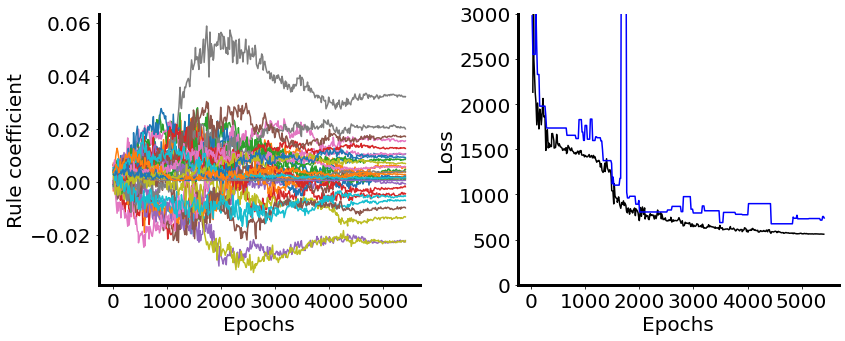

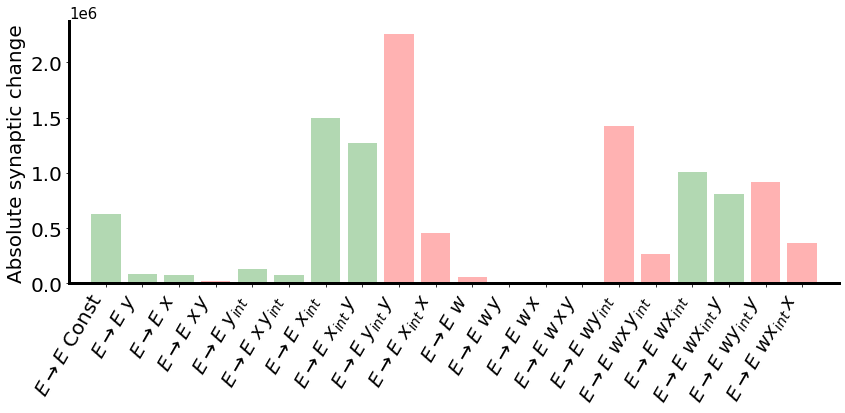

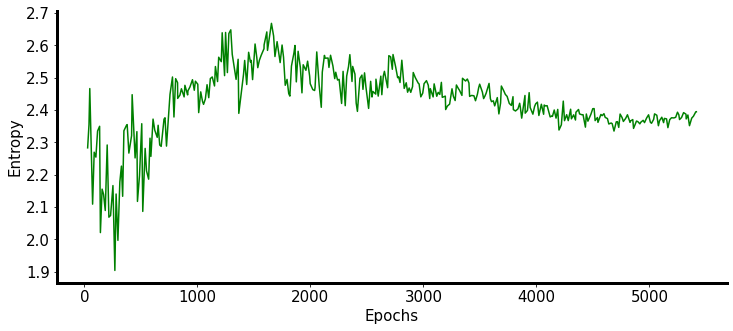

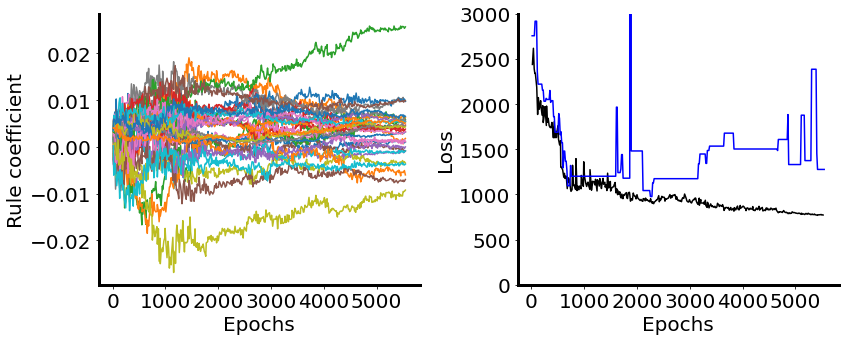

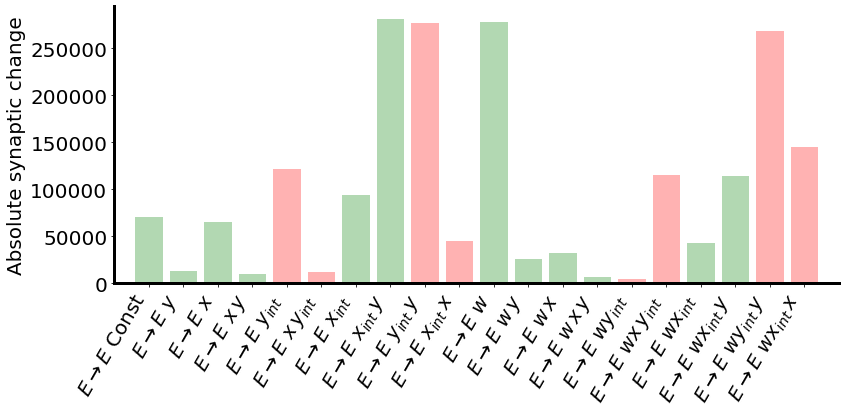

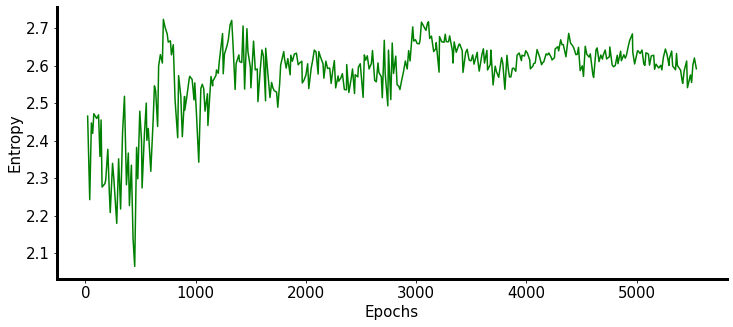

In [4]:
all_files = [
    'decoder_ee_2_with_test_loss_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_1e-06_1e-06_1e-06_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_6000_2023-06-28_15:18:07.738429',
    'decoder_ee_2_with_test_loss_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_1e-05_1e-05_1e-05_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_6000_2023-06-28_16:47:56.621924',
]

plot_all_opt_runs(all_files, 20, 12, 10, l_thresh=500, n_categories=1, name='ee_unperturbed_fixed_input')

ValueError: need at least one array to stack

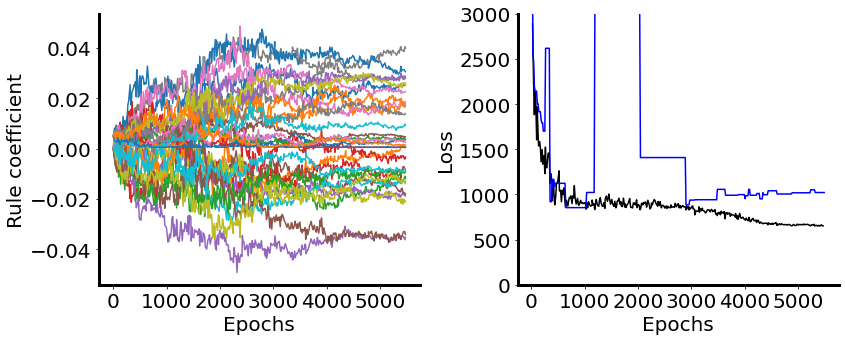

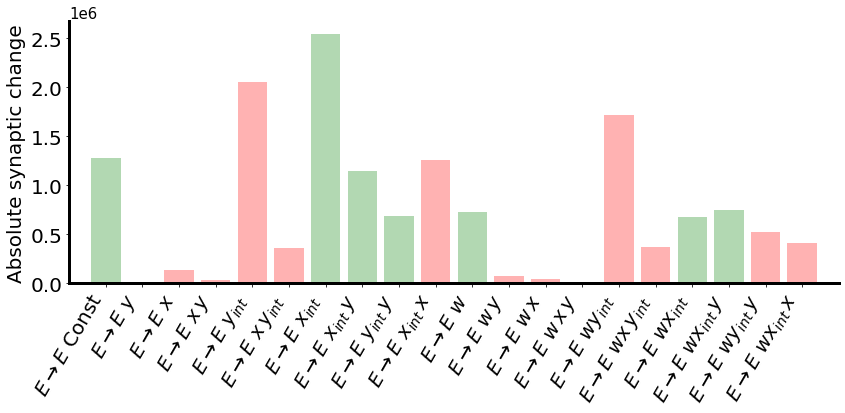

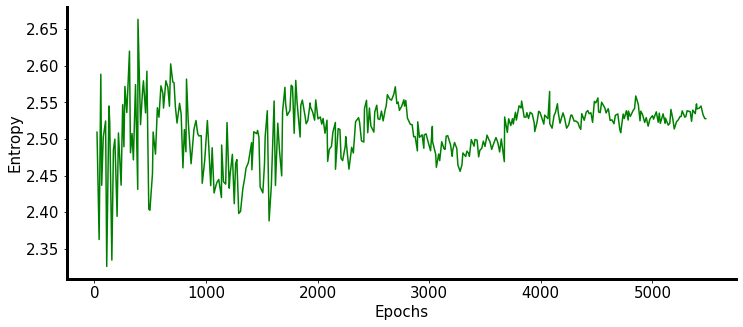

In [6]:
all_files = [
    'decoder_ee_2_with_test_loss_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_1e-06_1e-06_1e-06_ACT_PEN_1_CHANGEP_0.0007_FRACI_0.75_SEED_6000_2023-06-28_15:23:25.268692',
]

plot_all_opt_runs(all_files, 20, 12, 10, l_thresh=500, n_categories=1, name='ee_perturbed_fixed_input')

decoder_ee_2_reduced_act_pen_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_6000_2023-05-31_10:27:28.126331
decoder_ee_2_reduced_act_pen_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_6001_2023-05-31_10:27:27.894879
decoder_ee_2_reduced_act_pen_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_6002_2023-06-02_22:59:05.788902
[ 0.02514099 -0.02024071  0.01788894  0.03226185 -0.02183422 -0.01278635
  0.00859549  0.03594652 -0.0094287  -0.00354649  0.01375723 -0.00103611
  0.00437043  0.03073715 -0.0165236  -0.01523774  0.01618995  0.0273951
 -0.02629948 -0.01052537  0.01450611  0.00996215  0.01118042  0.00912682
  0.0114291   0.01346874  0.00128815  0.01735738  0.01227225  0.00675288
  0.00332814  0.00795866]


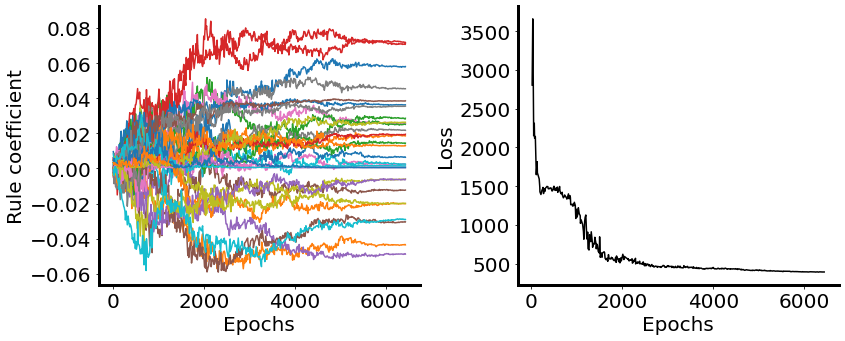

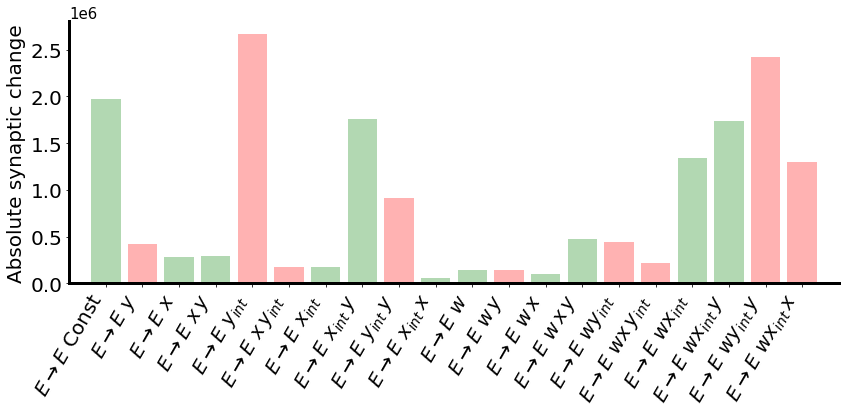

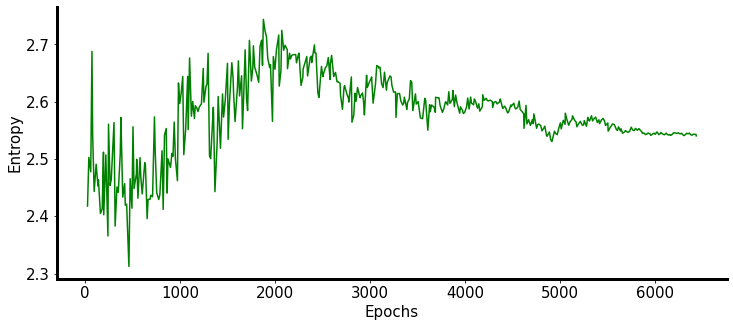

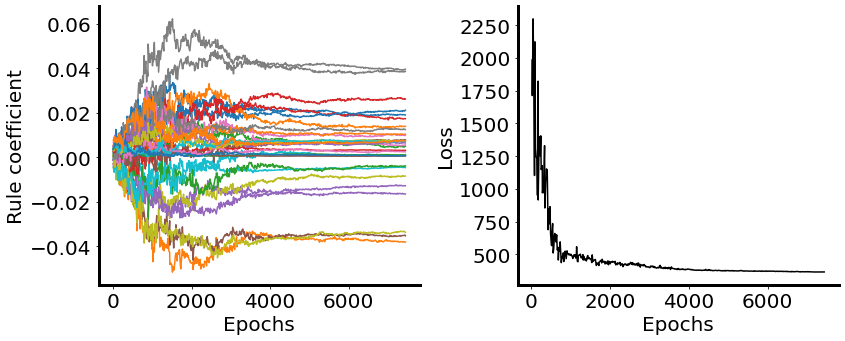

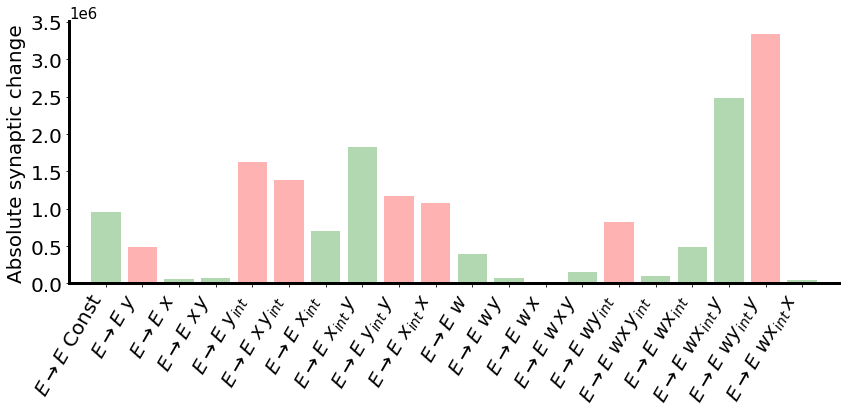

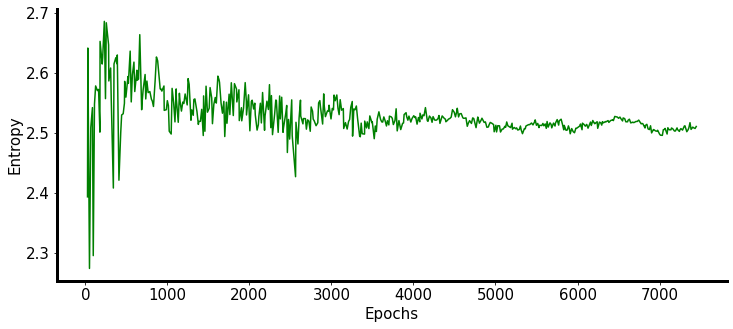

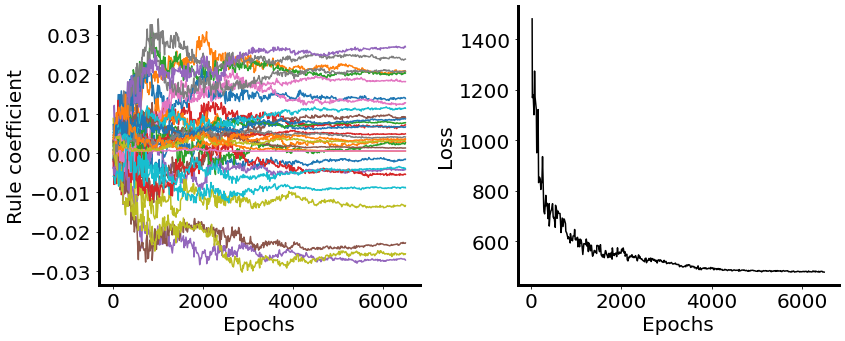

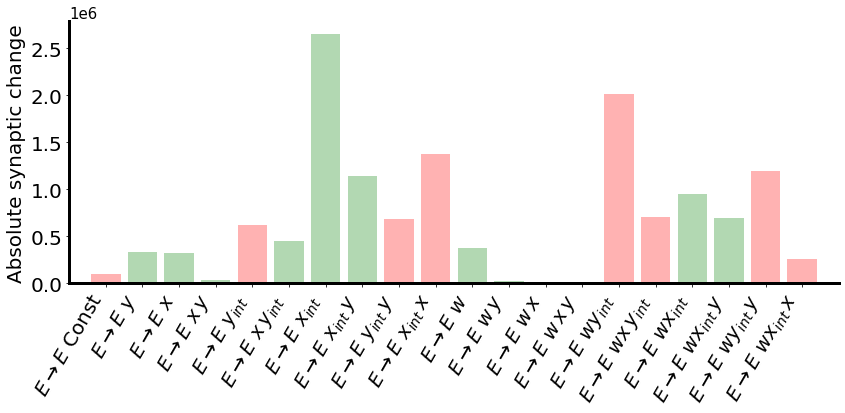

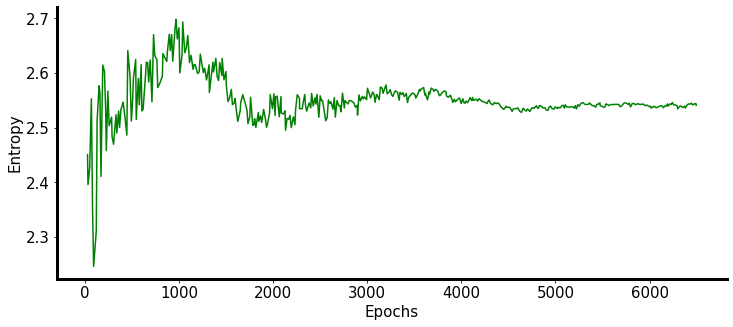

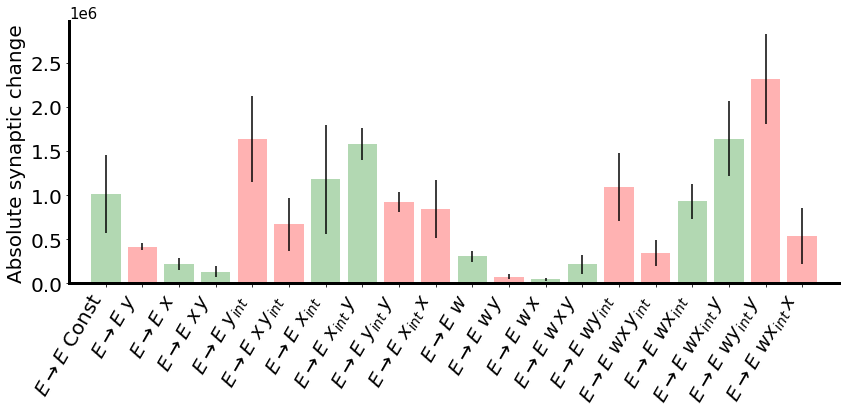

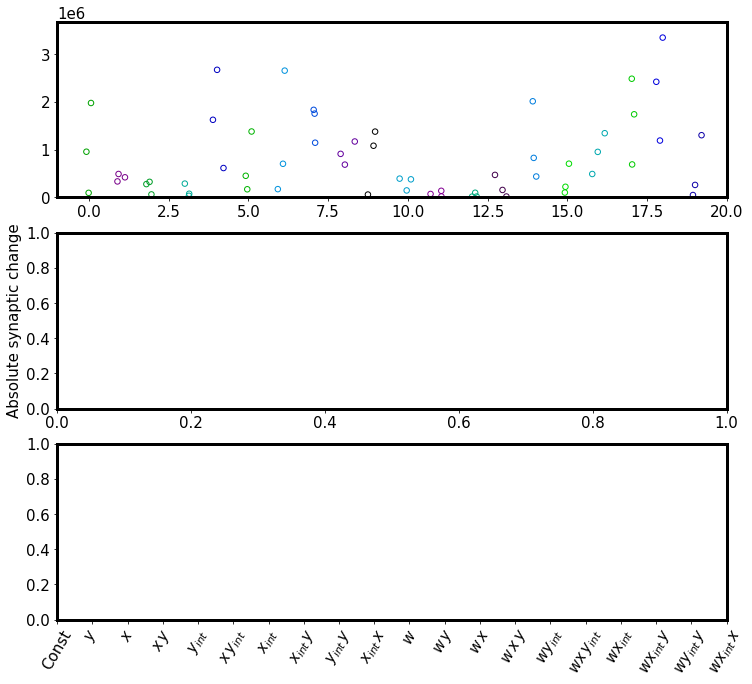

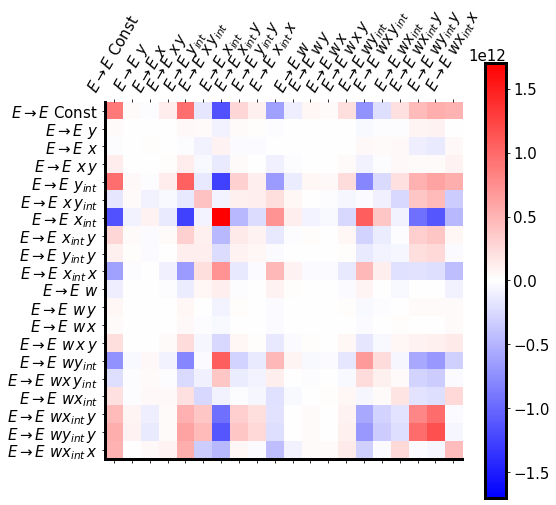

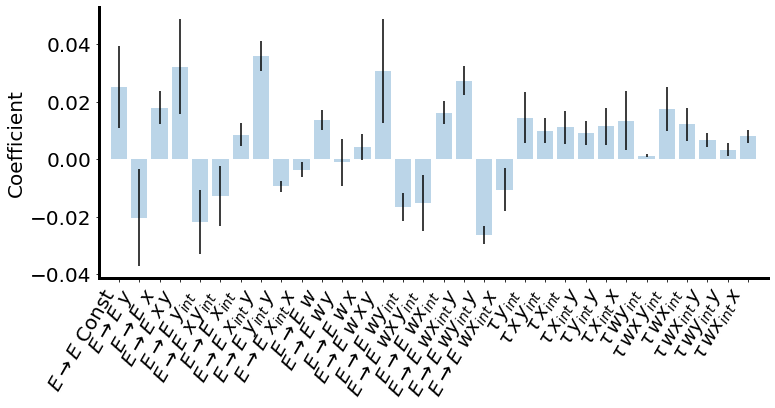

In [4]:
all_files = [
    'decoder_ee_2_reduced_act_pen_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_6000_2023-05-31_10:27:28.126331',
    'decoder_ee_2_reduced_act_pen_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_6001_2023-05-31_10:27:27.894879',
    'decoder_ee_2_reduced_act_pen_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_6002_2023-06-02_22:59:05.788902',
]

plot_all_opt_runs(all_files, 20, 12, 10, l_thresh=500, n_categories=1, name='ee_unperturbed')

decoder_ee_2_reduced_act_pen_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.001_FRACI_0.75_SEED_6000_2023-05-31_10:28:18.972929
decoder_ee_2_reduced_act_pen_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.001_FRACI_0.75_SEED_6001_2023-05-31_10:28:42.337351
decoder_ee_2_reduced_act_pen_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.001_FRACI_0.75_SEED_6002_2023-06-02_22:59:05.785824
[ 2.96163997e-02 -1.21147653e-02  8.78199815e-03  1.20211371e-02
  8.13406053e-04 -1.43514820e-02  2.49200180e-03  3.87059438e-02
  5.03101045e-04  3.96075963e-06 -7.00365242e-04  1.02580989e-02
  3.09265052e-02 -1.08241639e-02 -2.16573509e-02  6.58986566e-03
  1.63480622e-02  6.29106690e-03 -4.83612665e-02 -2.32352935e-02
  1.65633183e-02  2.52273255e-02  2.01142815e-02  8.35964571e-03
  1.46054547e-02  1.54047901e-02  1.45932579e-02  3.59114962e-03
  1.65644429e-03  8.48977490e-03  6.37787915e-03  1.31373587e-02]


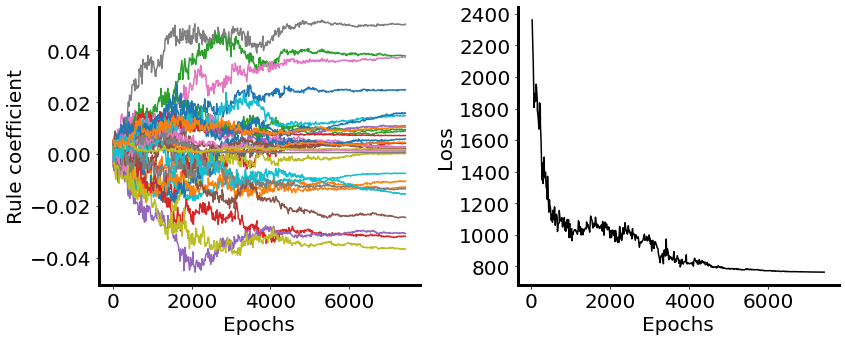

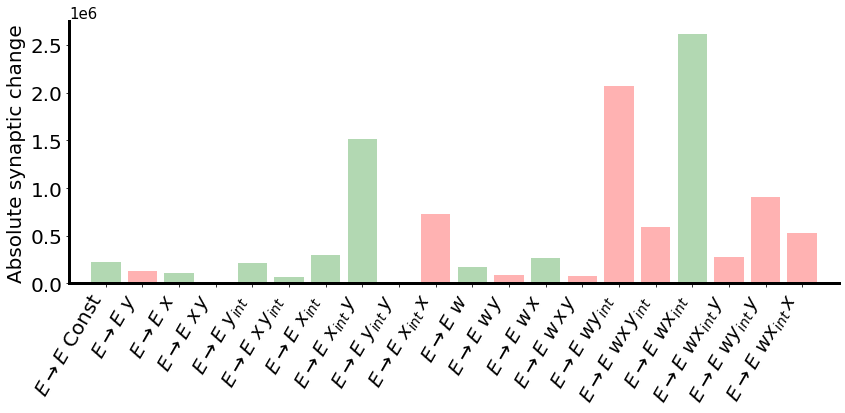

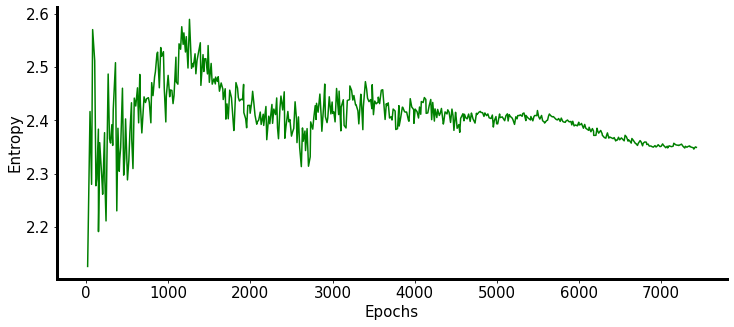

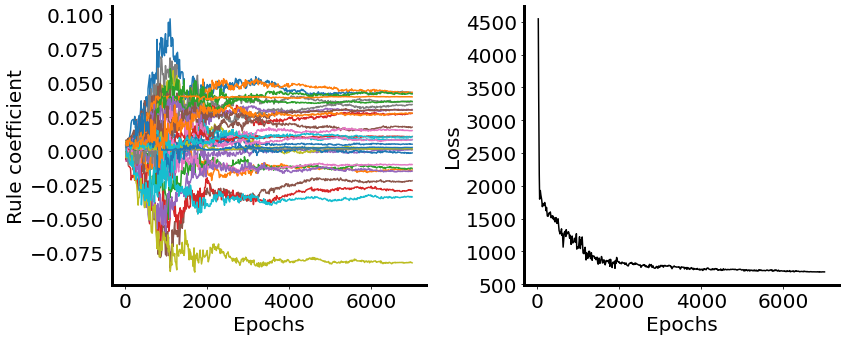

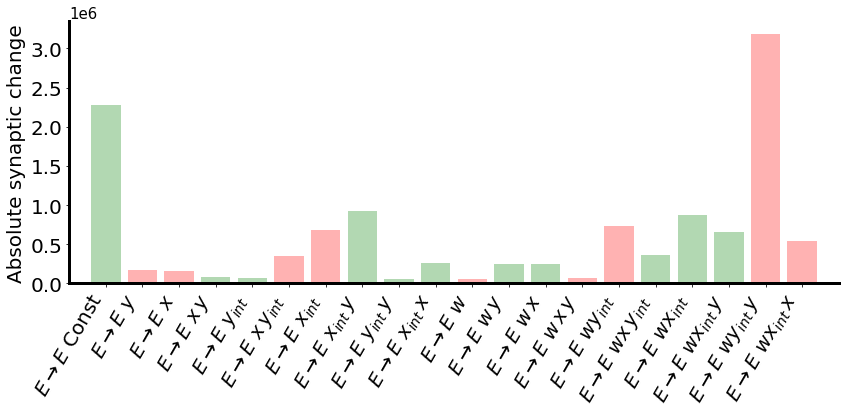

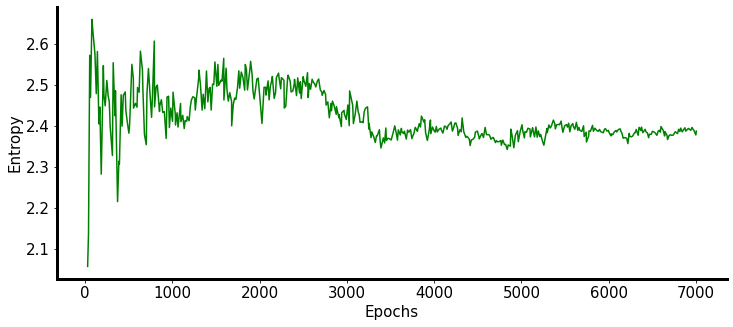

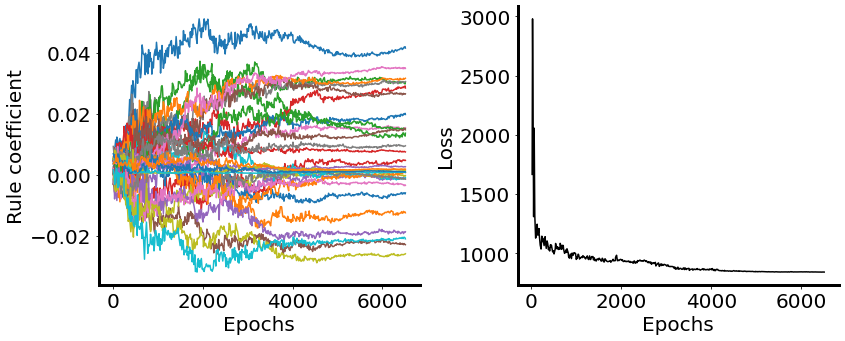

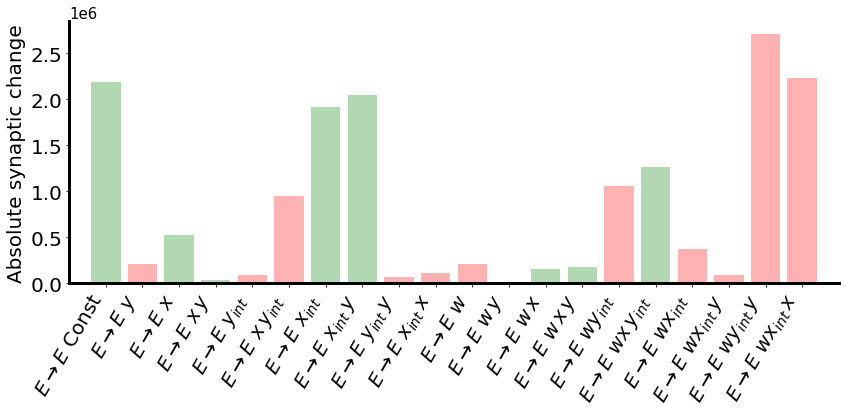

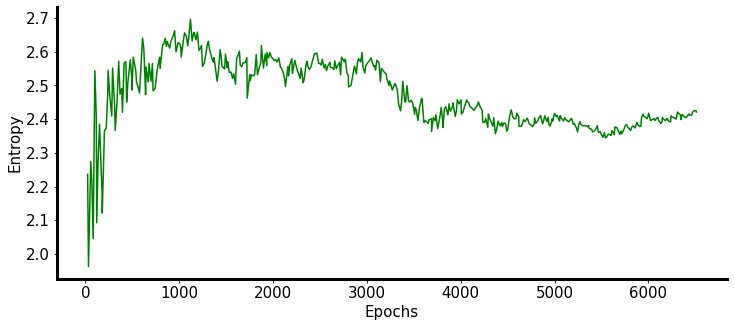

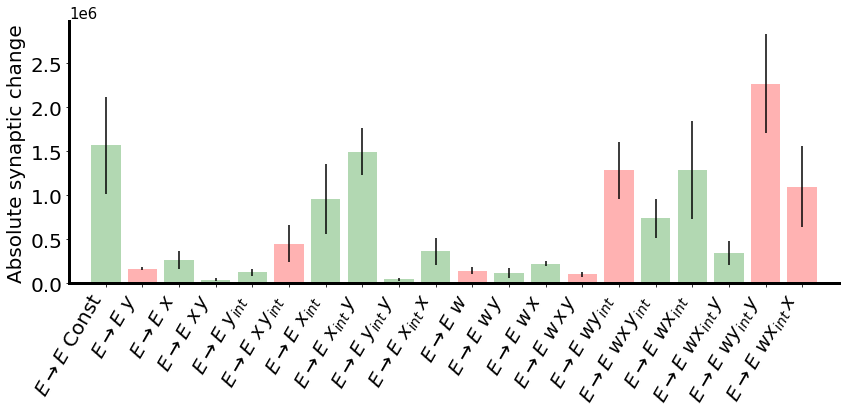

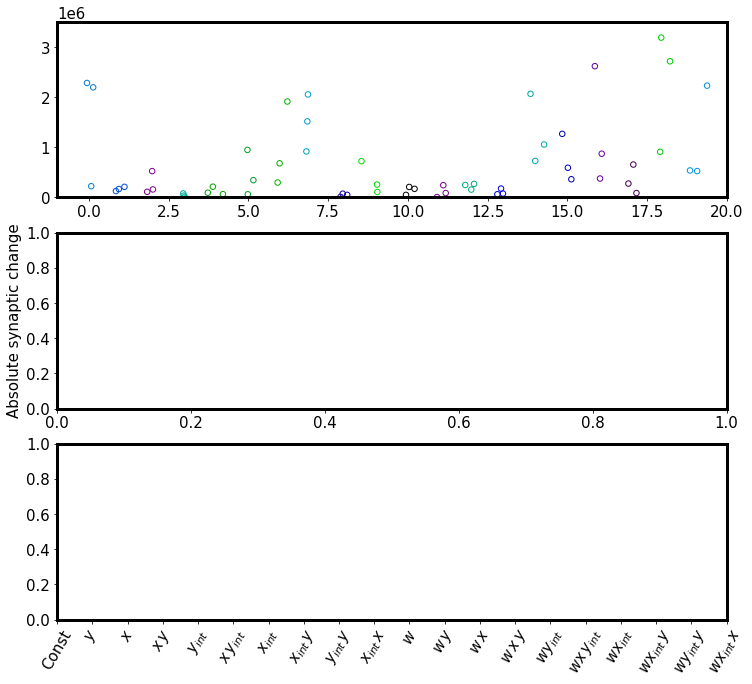

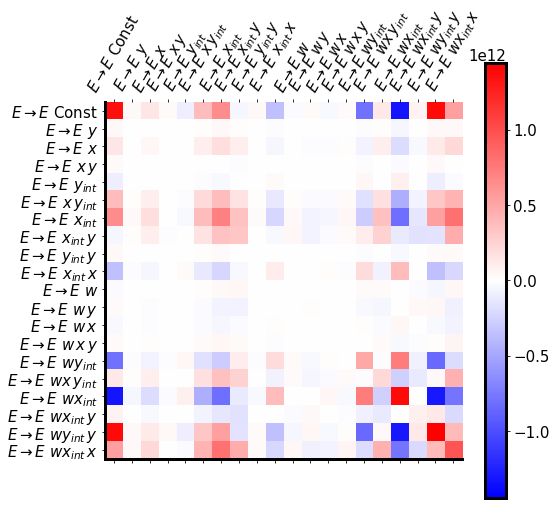

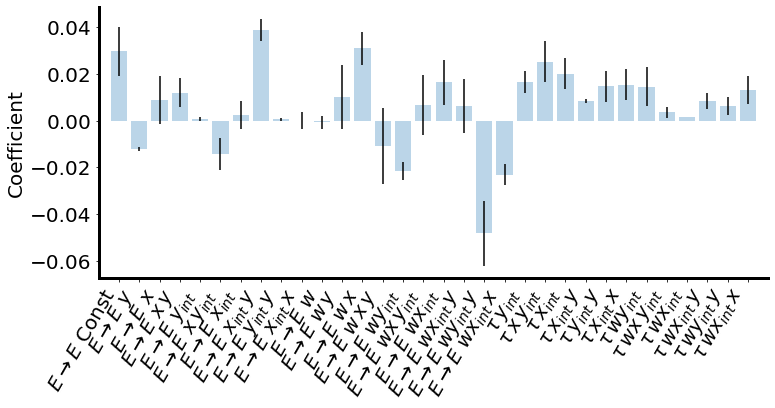

In [5]:
all_files = [
    'decoder_ee_2_reduced_act_pen_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.001_FRACI_0.75_SEED_6000_2023-05-31_10:28:18.972929',
    'decoder_ee_2_reduced_act_pen_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.001_FRACI_0.75_SEED_6001_2023-05-31_10:28:42.337351',
    'decoder_ee_2_reduced_act_pen_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.001_FRACI_0.75_SEED_6002_2023-06-02_22:59:05.785824',
]

plot_all_opt_runs(all_files, 20, 12, 10, l_thresh=1000, n_categories=1, name='ee_perturbed')

decoder_all_small_act_pen_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_6002_2023-05-31_10:09:29.595032
seq_self_org_decoder_all_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_6004_2023-06-02_23:02:46.161151
seq_self_org_decoder_all_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_6005_2023-06-02_23:02:51.021531
[ 7.07943437e-03  2.71127665e-03  3.59823026e-03  8.22179649e-03
  1.44715648e-03 -8.67338488e-03  1.79168378e-03  4.02202182e-02
 -2.18745737e-02  4.31893201e-03  7.79102277e-03 -2.57617276e-03
  1.05104852e-02 -3.70189319e-03 -1.03096749e-02 -8.37658778e-05
  5.89292454e-03  1.22630131e-02 -2.68134814e-02 -2.85793197e-03
  1.15679262e-02  5.60621846e-03  1.95570526e-03 -1.99262067e-03
 -3.41801975e-03 -1.23347752e-02 -2.80310764e-04  1.52321597e-02
  7.37601104e-03  2.01534349e-02 -1.06377140e-02 -8.20039601e-03
 -9.65777406e-03 -1.

ValueError: The number of FixedLocator locations (96), usually from a call to set_ticks, does not match the number of ticklabels (72).

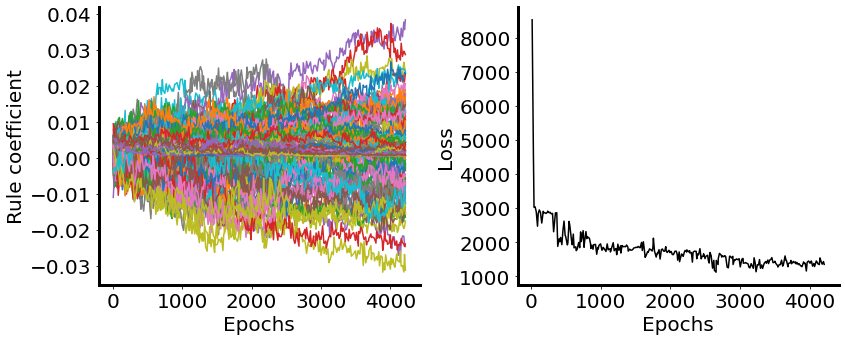

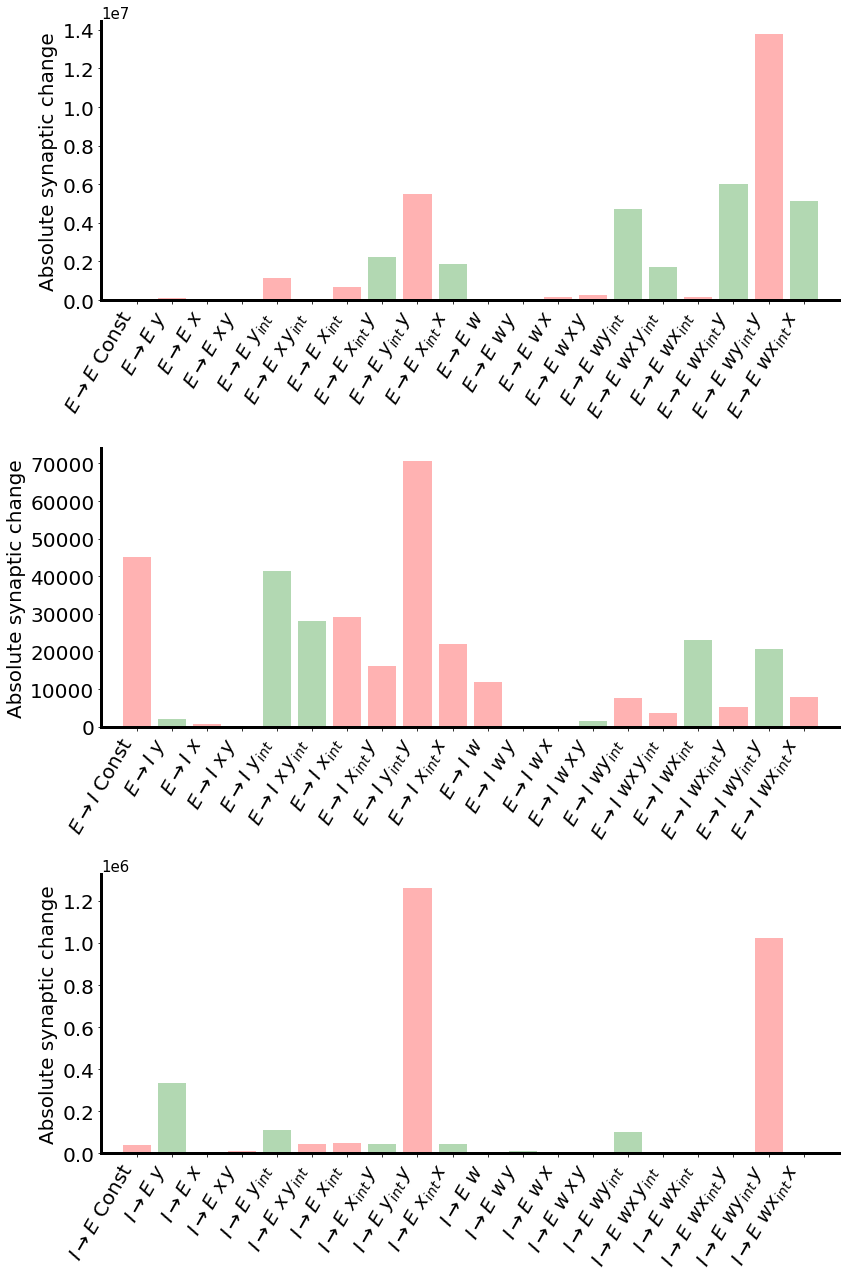

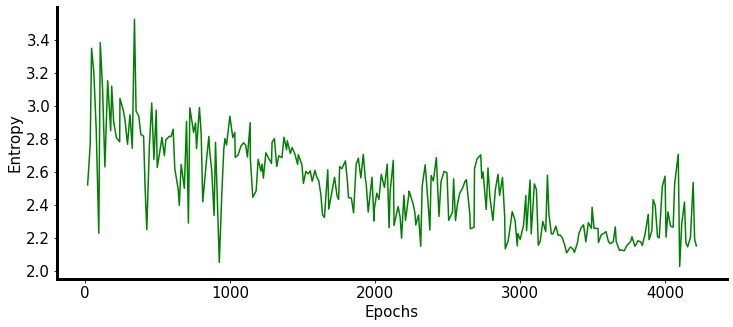

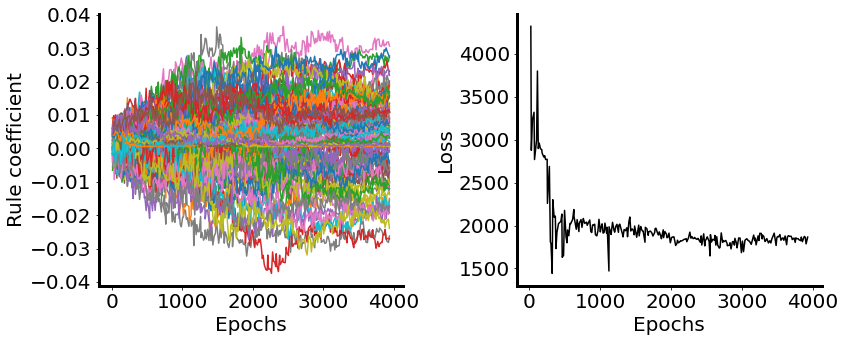

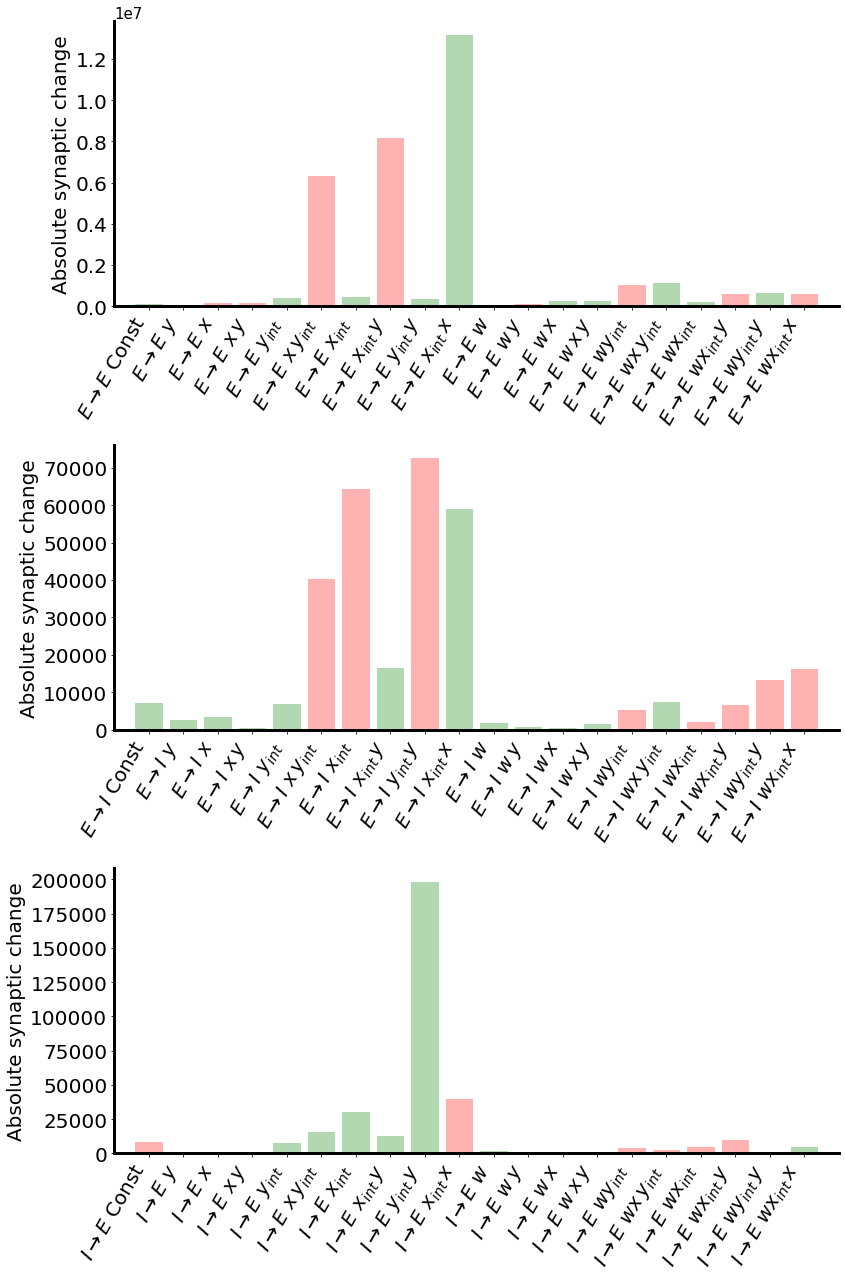

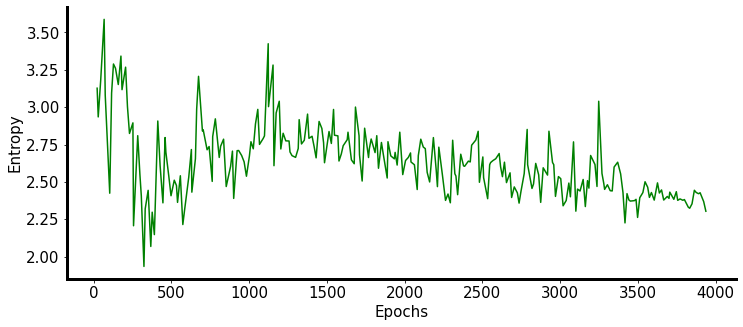

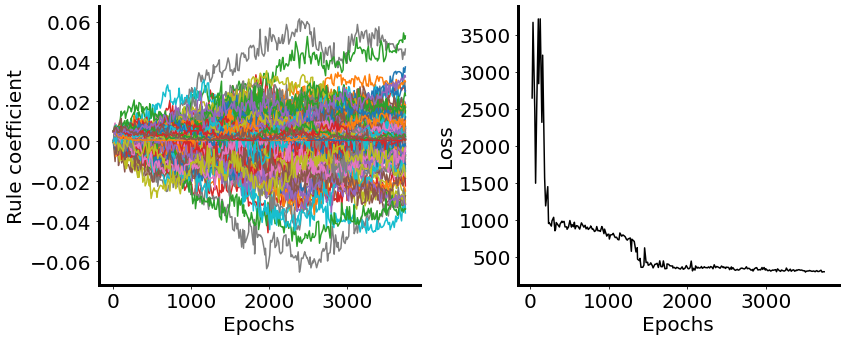

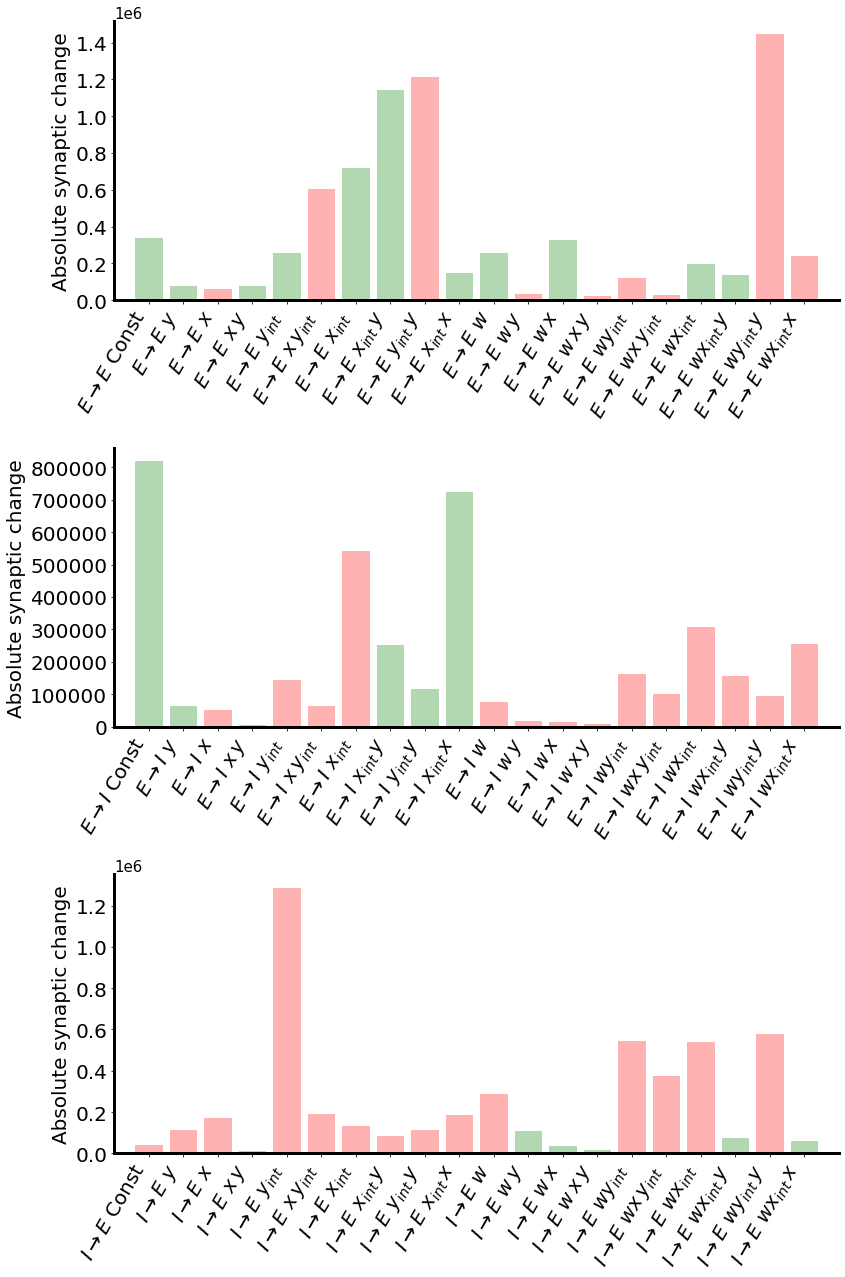

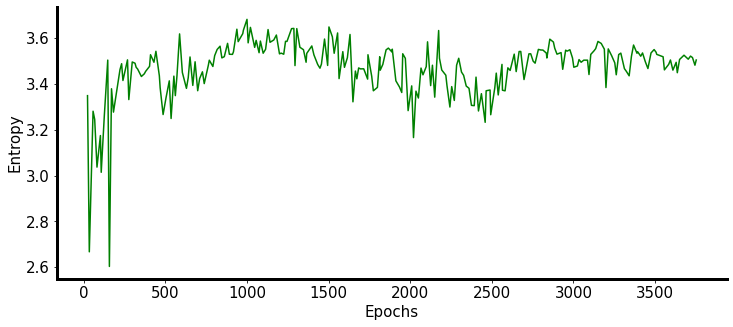

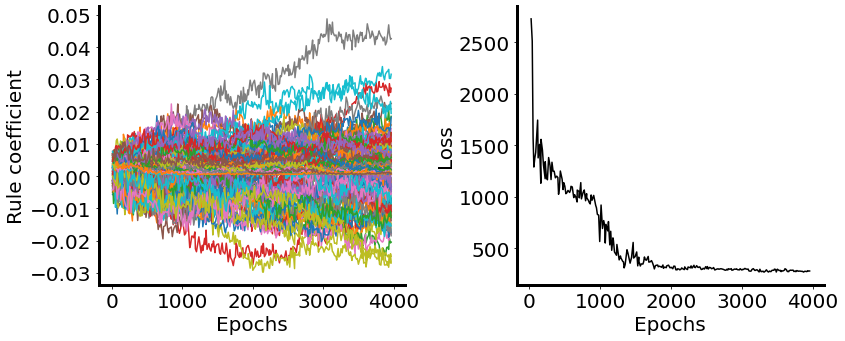

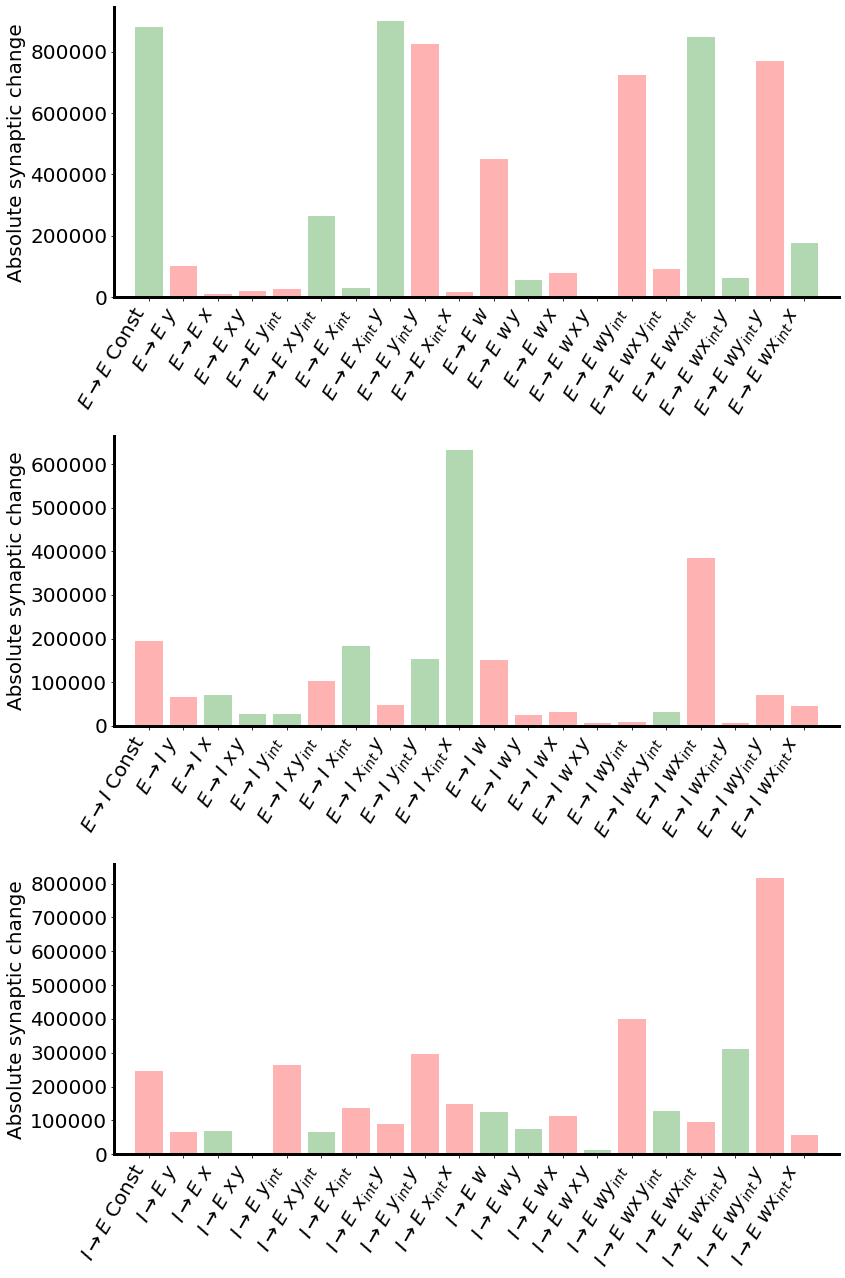

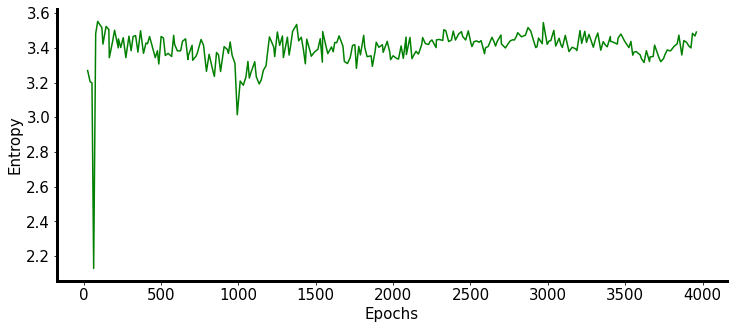

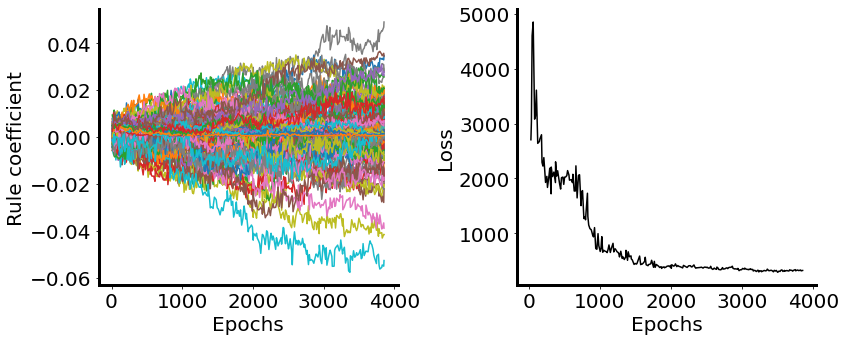

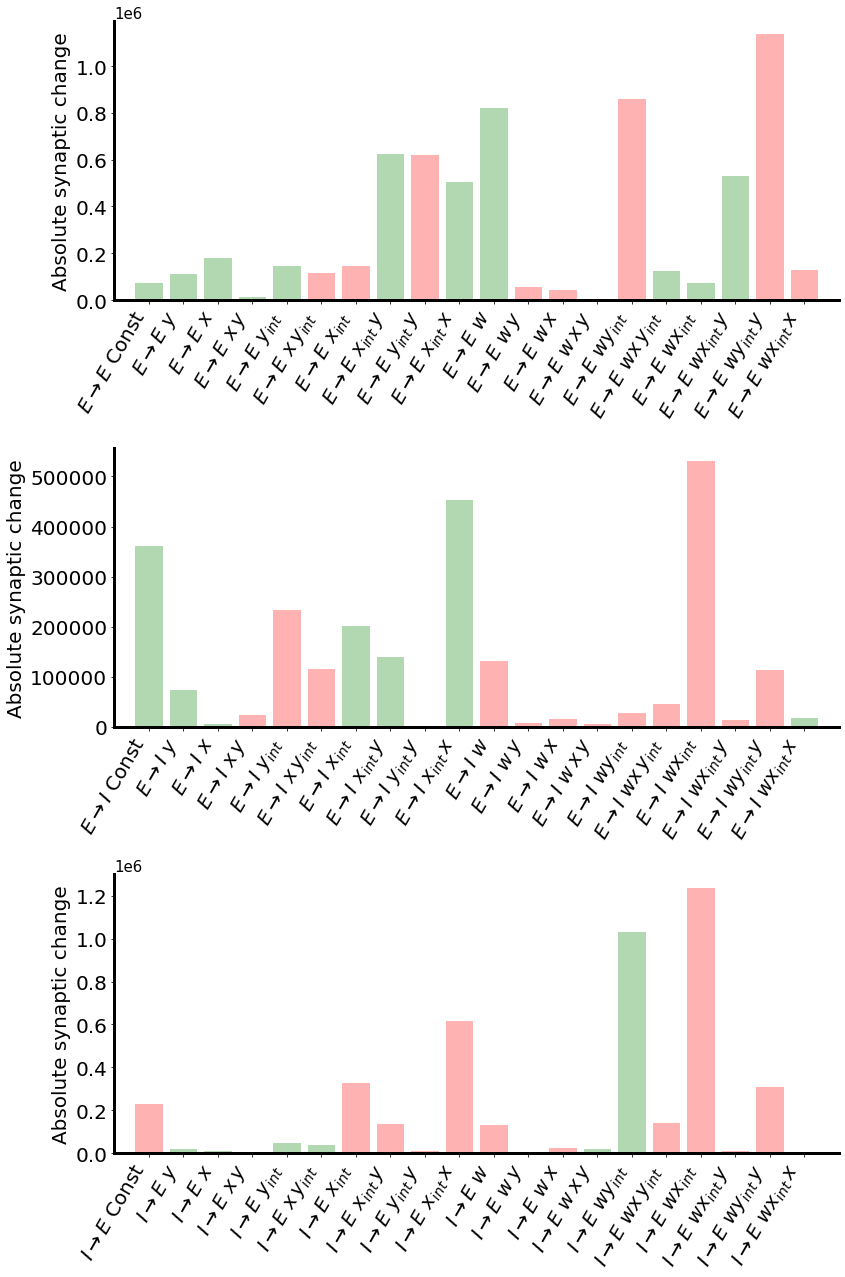

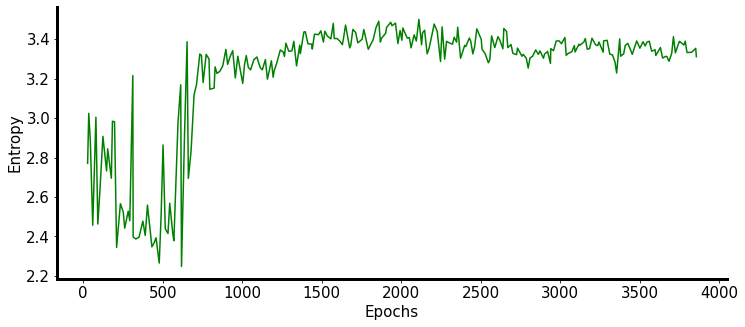

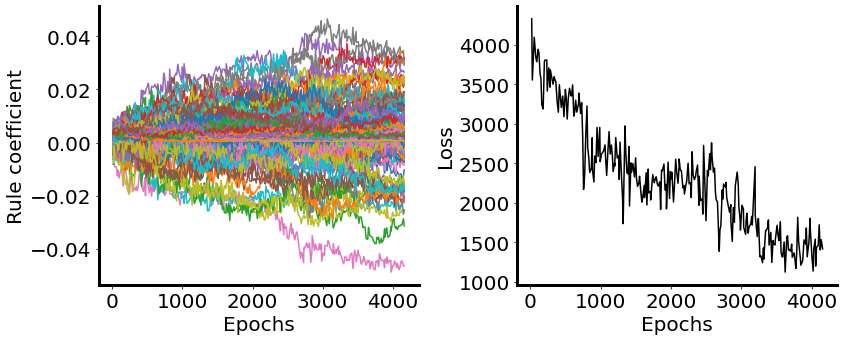

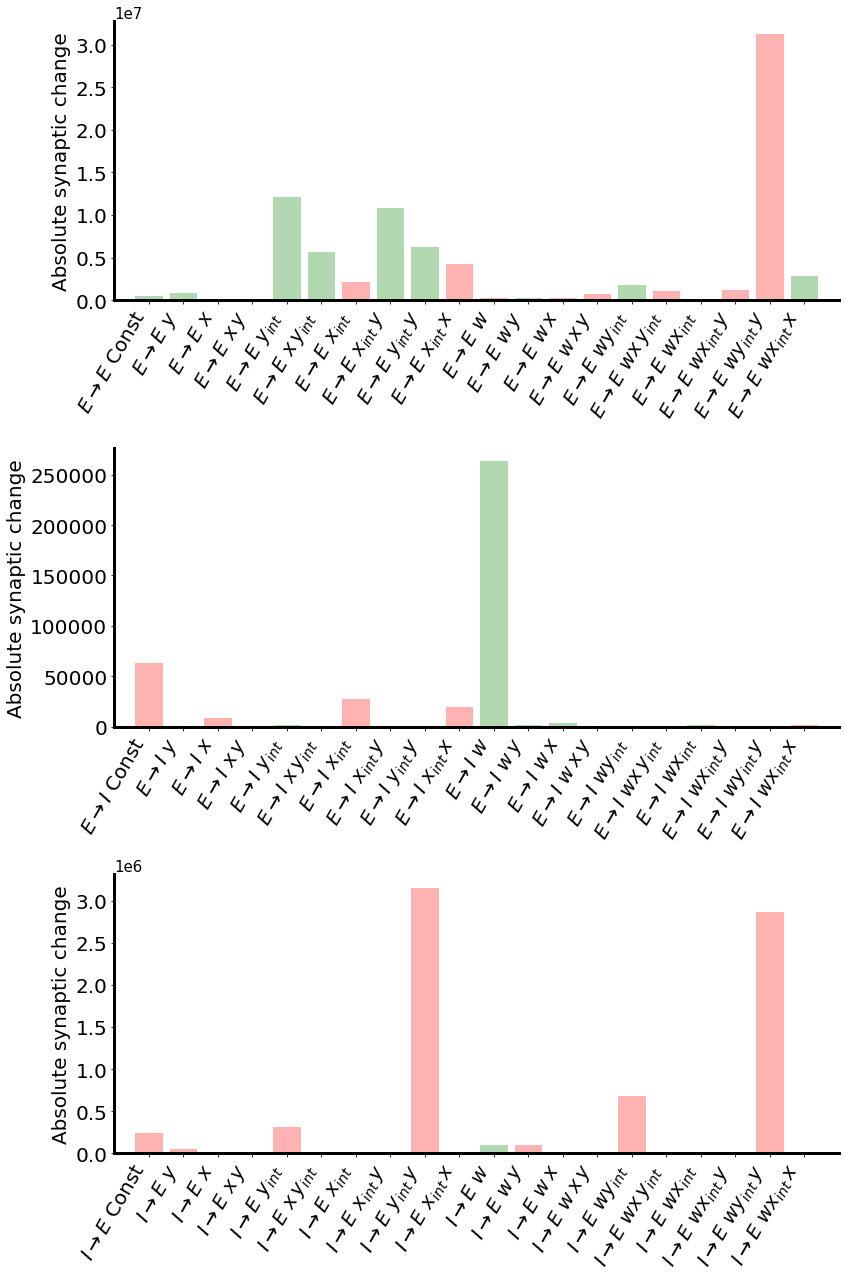

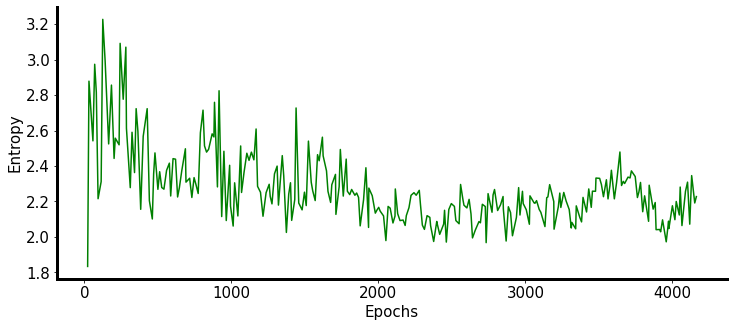

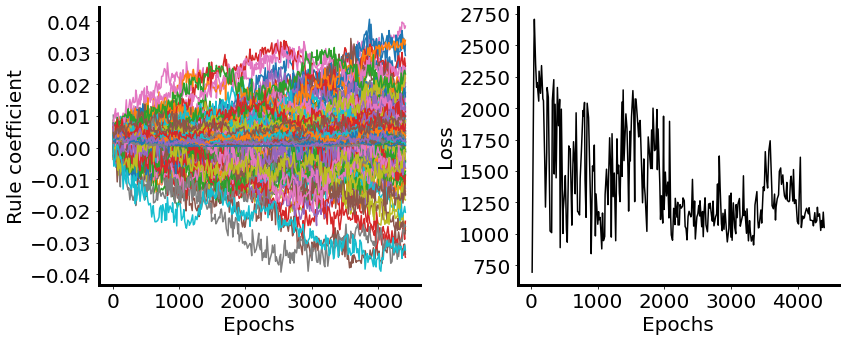

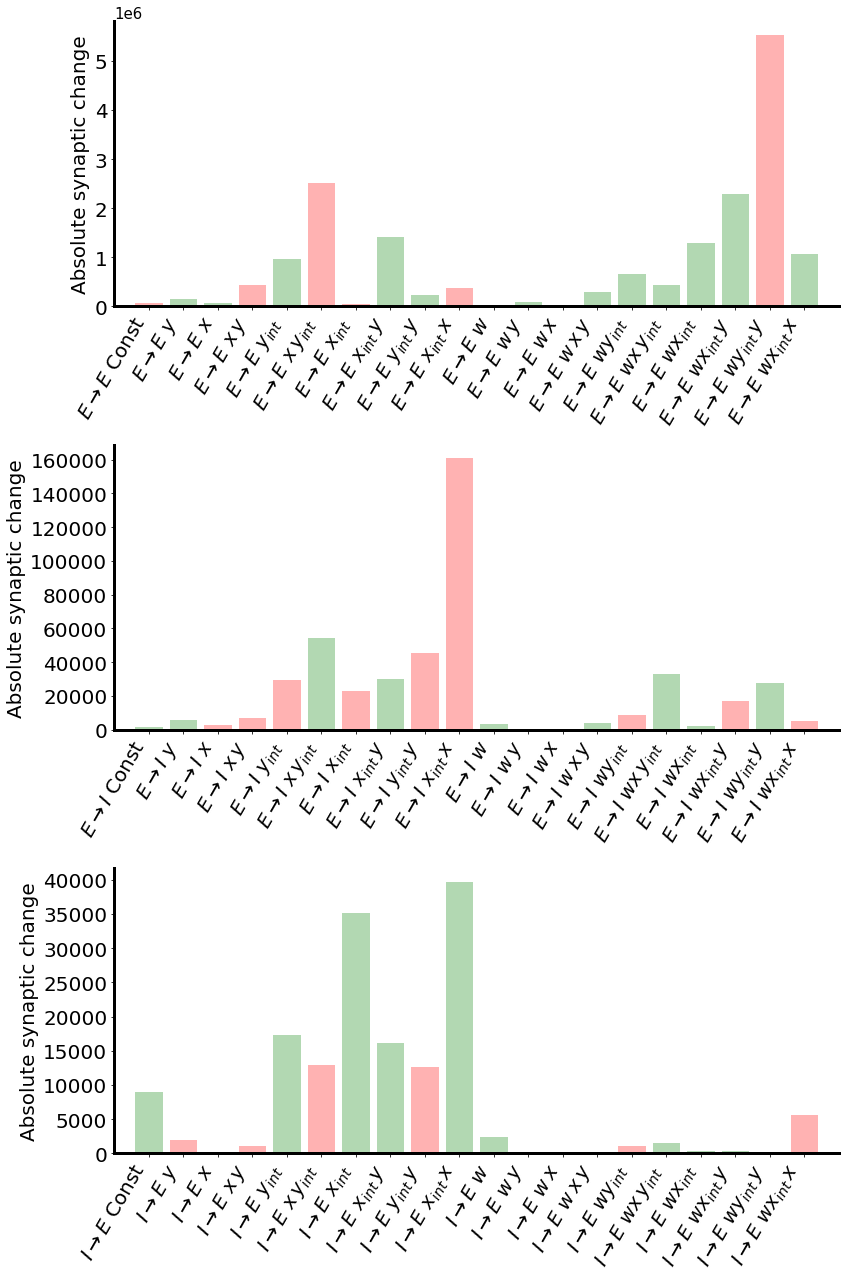

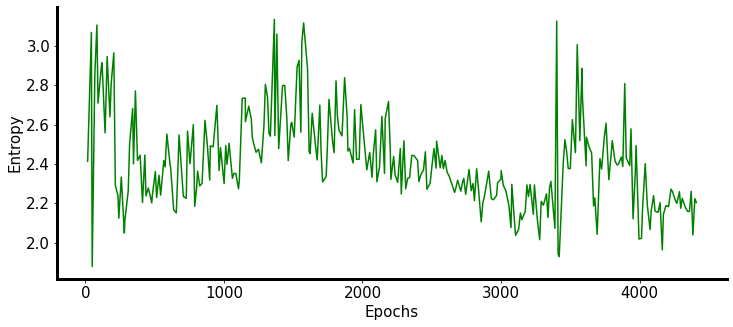

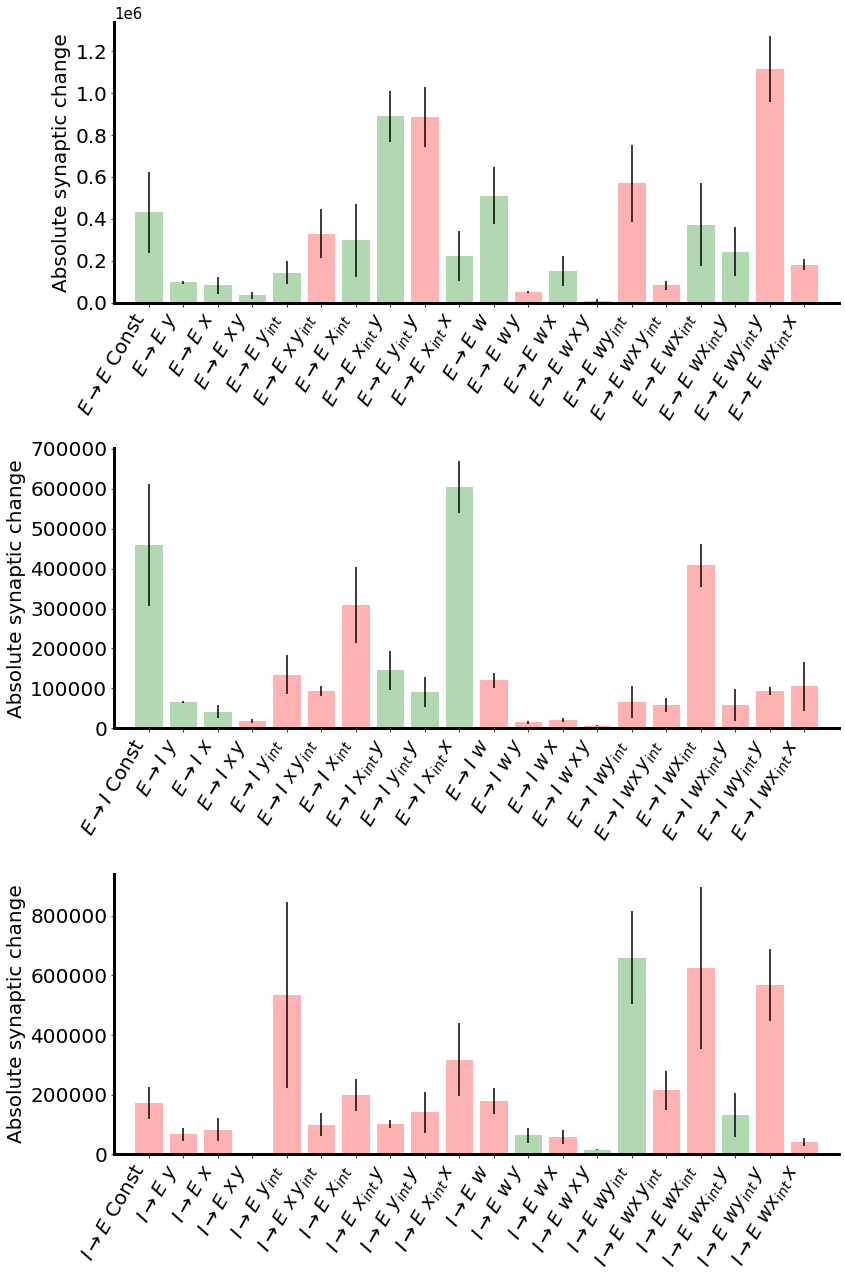

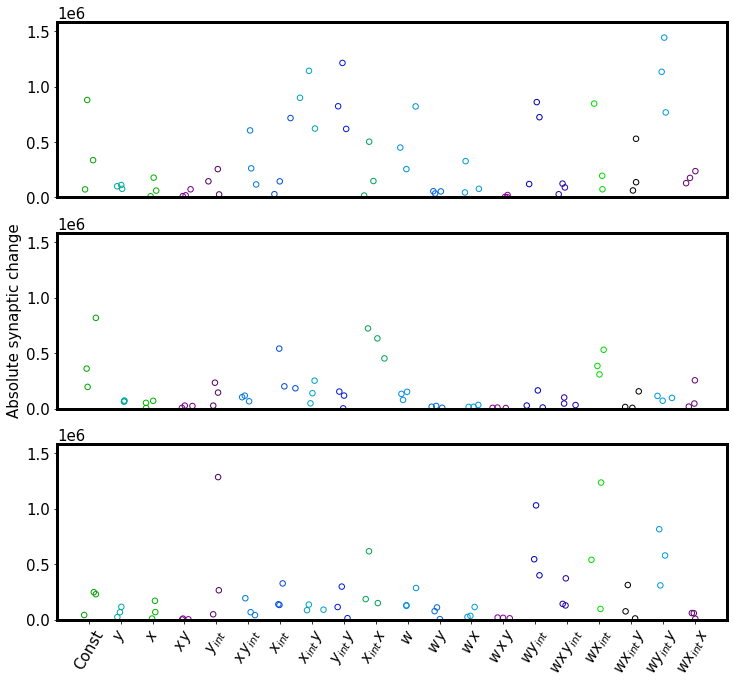

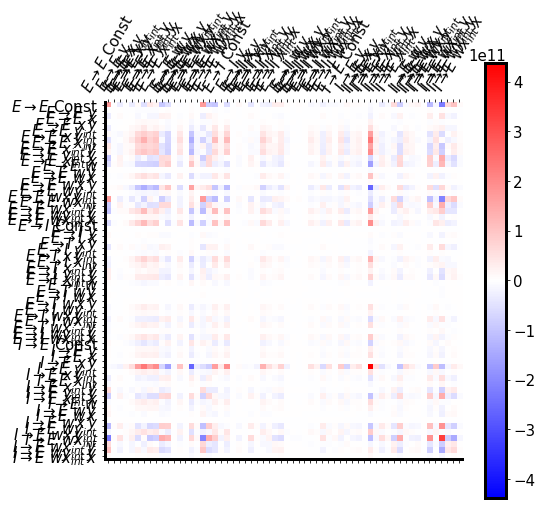

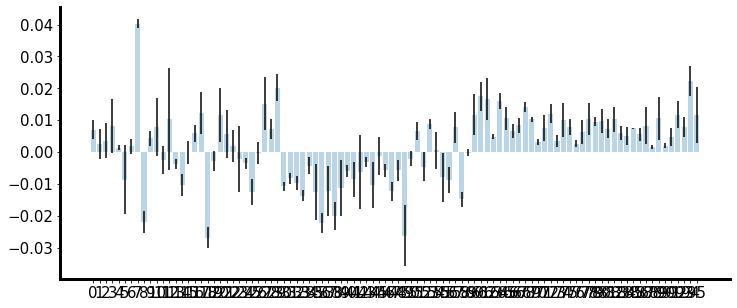

In [6]:
all_files = [
    'decoder_all_small_act_pen_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_6000_2023-05-31_10:08:41.348490',
    'decoder_all_small_act_pen_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_6001_2023-05-31_10:09:29.557758',
    'decoder_all_small_act_pen_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_6002_2023-05-31_10:09:29.595032',
    'seq_self_org_decoder_all_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_6004_2023-06-02_23:02:46.161151',
    'seq_self_org_decoder_all_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_6005_2023-06-02_23:02:51.021531',
    'seq_self_org_decoder_all_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_6006_2023-06-02_23:04:39.747824',
    'seq_self_org_decoder_all_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_6007_2023-06-02_23:04:51.469174',
]

plot_all_opt_runs(all_files, 60, 36, 10, l_thresh=500, n_categories=3, name='all_unperturbed')

In [9]:
def load_best_avg_params(file_name, n_plasticity_coefs, n_time_constants, batch_size, n_categories=1):
    figure_path = f'./figures/{file_name}'
    Path(figure_path).mkdir(parents=True, exist_ok=True)
    
    scale = 2
    gs = gridspec.GridSpec(5 * n_categories, 1)
    fig = plt.figure(figsize=(6 * scale, 3 * n_categories * scale), tight_layout=True)
    axs = []
    for i in range(n_categories):
        axs.append([fig.add_subplot(gs[i * 3: i * 3 + 2]), fig.add_subplot(gs[i * 3 + 2:i * 3 + 5])])
        
    gs_2 = gridspec.GridSpec(5 * n_categories, 1)
    fig_2 = plt.figure(figsize=(6 * scale, 3 * n_categories * scale), tight_layout=True)
    axs_2 = []
    for i in range(n_categories):
        axs_2.append([fig_2.add_subplot(gs_2[i * 3: i * 3 + 2]), fig_2.add_subplot(gs_2[i * 3 + 2:i * 3 + 5])])
        
    cutoff = 500
    
    for ax in [axs, axs_2]:
        ax[0][1].set_ylabel('Loss')
        ax[0][0].set_xticks([])
        ax[0][1].set_xticks(np.arange(n_plasticity_coefs + 1))
        ax[0][0].set_xticklabels([])
        ax[0][1].set_xticklabels(np.concatenate([['None'], rule_names[:n_plasticity_coefs]]), rotation=60, ha='right')
        
        ax[0][0].set_yscale('log')
        ax[0][0].set_ylim(100, 1e9)
        ax[0][1].set_ylim(0, cutoff)
        ax[0][0].set_xlim(-1, n_plasticity_coefs + 1)
        ax[0][1].set_xlim(-1, n_plasticity_coefs + 1)
        
        ax[0][0].spines['bottom'].set_visible(False)
        ax[0][0].spines['right'].set_visible(False)
        ax[0][1].spines['top'].set_visible(False)
        ax[0][1].spines['right'].set_visible(False)
        
    
    train_data_path = f'./sims_out/{file_name}/train_data.csv'
    df_train = read_csv(train_data_path, read_header=False)

    syn_effect_start = 2 + batch_size + n_plasticity_coefs + n_time_constants
    syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_time_constants + n_plasticity_coefs
    plasticity_coefs_start = 2 + batch_size
    plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs + n_time_constants

    losses = df_train[df_train.columns[1]]
    
    all_losses_for_dropouts = np.array([losses[i:i + 30] for i in range(0, (n_plasticity_coefs + 1) * 30, 30)])
    mean_losses_for_dropouts = np.array([np.mean(ls) for ls in all_losses_for_dropouts])
    std_losses_for_dropouts = np.array([np.std(ls) for ls in all_losses_for_dropouts])
    cis_for_dropouts = 1.2 * (std_losses_for_dropouts / np.sqrt(30))
    
    sig_diff = np.where(mean_losses_for_dropouts - cis_for_dropouts > mean_losses_for_dropouts[0] + cis_for_dropouts[0], True, False)
    
    means_under_cutoff = mean_losses_for_dropouts < cutoff

    for i in range(0, (n_plasticity_coefs + 1) * 30, 30):
        idx = int(i/30)
        losses_for_dropout = losses[i:i + 30]
        
        color = 'red' if sig_diff[idx] else 'black'
        
        
        under_cutoff = losses_for_dropout < cutoff
        axs[0][0].scatter((np.ones(30) * idx + np.random.normal(size=30, scale=0.15))[~under_cutoff],
                    losses_for_dropout[~under_cutoff], marker='o', facecolor='none', edgecolor=color)
        axs[0][1].scatter((np.ones(30) * idx + np.random.normal(size=30, scale=0.15))[under_cutoff],
                    losses_for_dropout[under_cutoff], marker='o', facecolor='none', edgecolor=color)
    
    
        if not means_under_cutoff[idx]:
            axs_2[0][0].errorbar([idx],
                        mean_losses_for_dropouts[idx],
                        yerr=cis_for_dropouts[idx], color=color, capsize=4, linestyle='')
            axs_2[0][0].scatter([idx],
                        mean_losses_for_dropouts[idx], color=color)
        else:
            axs_2[0][1].errorbar([idx], 
                        mean_losses_for_dropouts[idx],
                        yerr=cis_for_dropouts[idx], color=color, capsize=4, linestyle='')
            axs_2[0][1].scatter([idx],
                        mean_losses_for_dropouts[idx], color=color)
    
    set_font_size(axs[0][0], 20)
    set_font_size(axs[0][1], 20)
    fig.savefig(os.path.join(figure_path, 'rule_perturbation.png'))
    fig.savefig(os.path.join(figure_path, 'rule_perturbation.svg'))
        

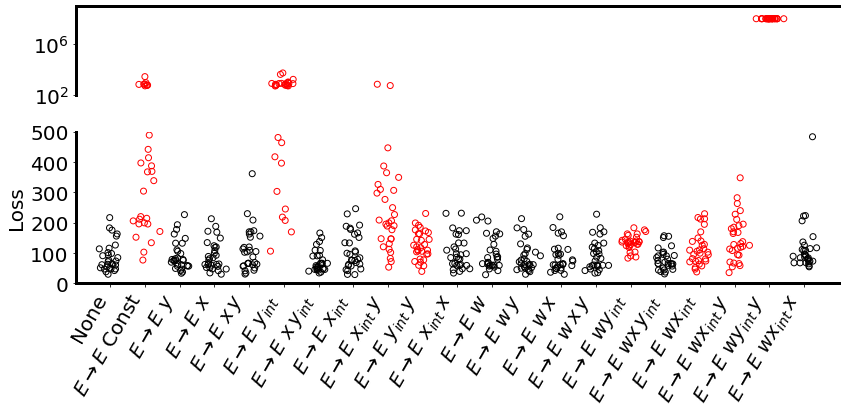

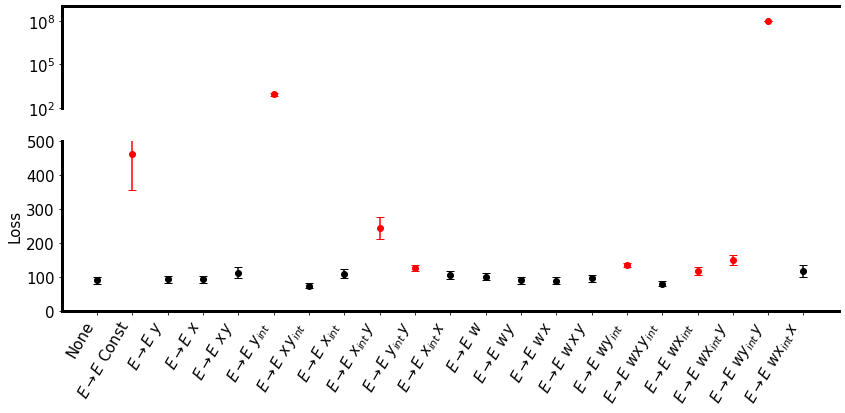

In [10]:
file_name = 'ee_no_syn_perturb_decoder_all_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_100_2023-06-07_15:34:37.394496'
load_best_avg_params(file_name, 20,12, 1, n_categories=1)

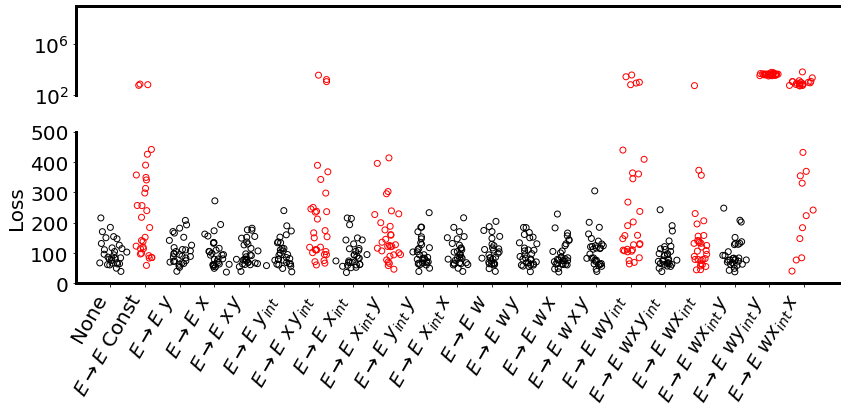

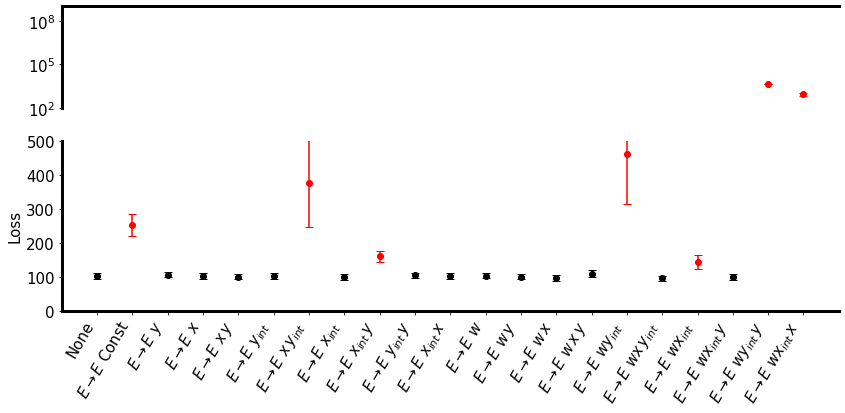

In [8]:
file_name = 'ee_syn_perturb_decoder_all_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.001_FRACI_0.75_SEED_100_2023-06-08_12:18:31.272425'
load_best_avg_params(file_name, 20,12, 1, n_categories=1)

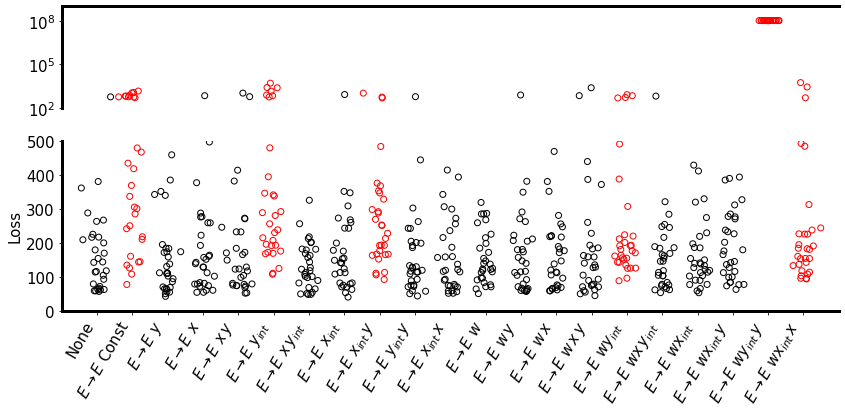

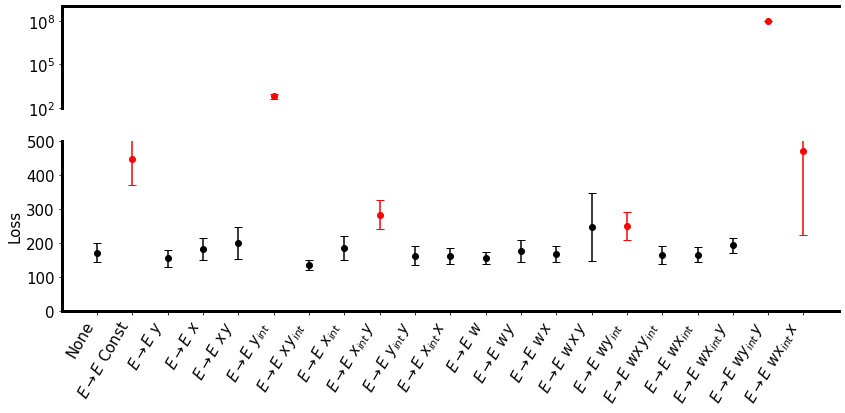

In [43]:
file_name = 'ee_syn_perturb_ns_train_decoder_all_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.001_FRACI_0.75_SEED_100_2023-06-08_12:27:37.371587'
load_best_avg_params(file_name, 20,12, 1, n_categories=1)

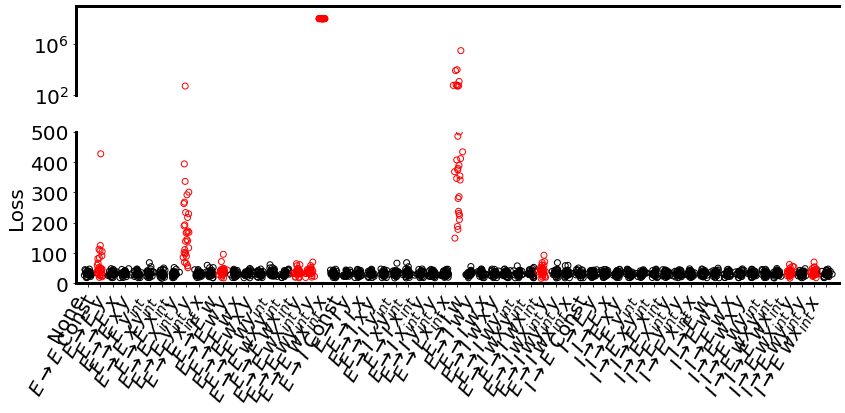

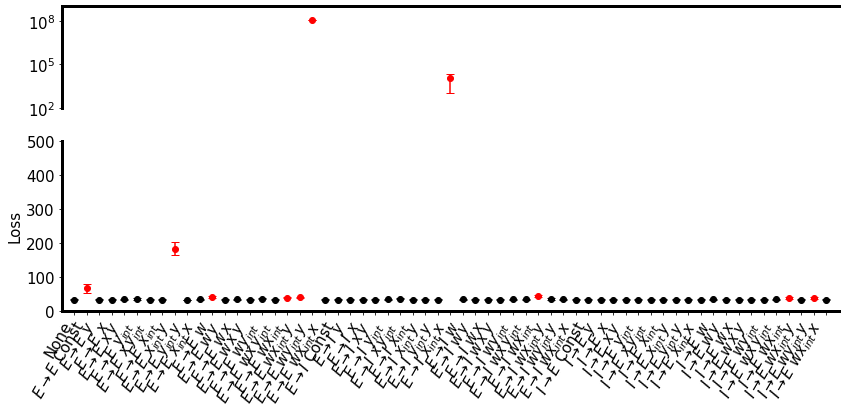

In [5]:
file_name = 'ei_test_decoder_all_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_100_2023-06-11_00:44:22.883486'
load_best_avg_params(file_name, 60, 36, 1, n_categories=1)
